In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
import operator

from utils import *

## Goose and Jester

### LR, 62CH, 10S

In [2]:
CH = 'all'
time_window = 10
device = torch.device('cuda')

val_dates = ['171021','171023','180711','180714']
test_dates = ['171020','171022','180712','180713']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_and_Jester'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=128)

val dates: ['171021', '171023', '180711', '180714'], test dates: ['171020', '171022', '180712', '180713']
val instances: 5892, val imbalance: 0.8616768717765808
test instances: 6318, test imbalance: 0.8211459517478943
train instances: 64060, train imbalance: 0.5


#### Without regularization

In [4]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 0.7615194320678711
Val loss for epoch 0: 1.5305851697921753
1
Train loss for epoch 1: 0.5222338438034058
Val loss for epoch 1: 1.3896783590316772
3
Train loss for epoch 3: 0.4846363365650177
Val loss for epoch 3: 1.3475475311279297


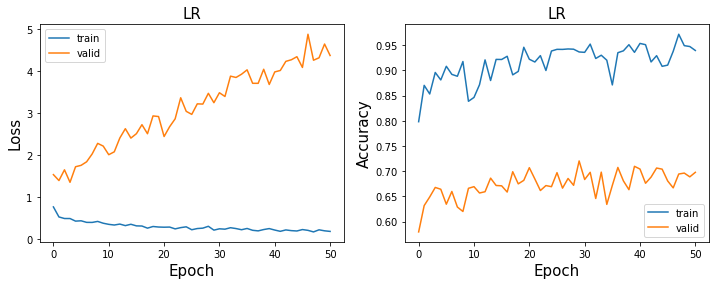

In [5]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

val loss:1.3475475311279297, val accuracy:0.6676849966055669, val percentage postive:0.8616768717765808


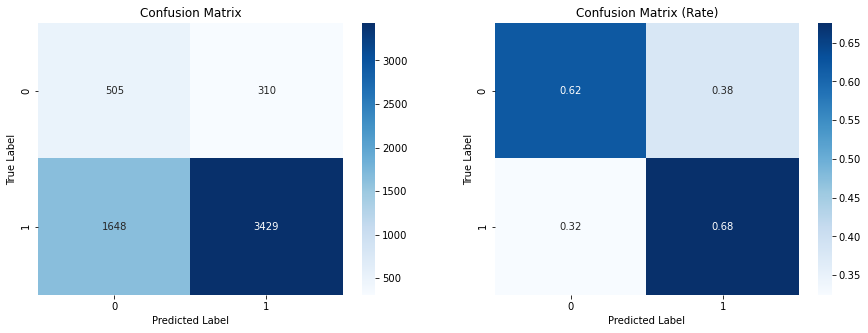

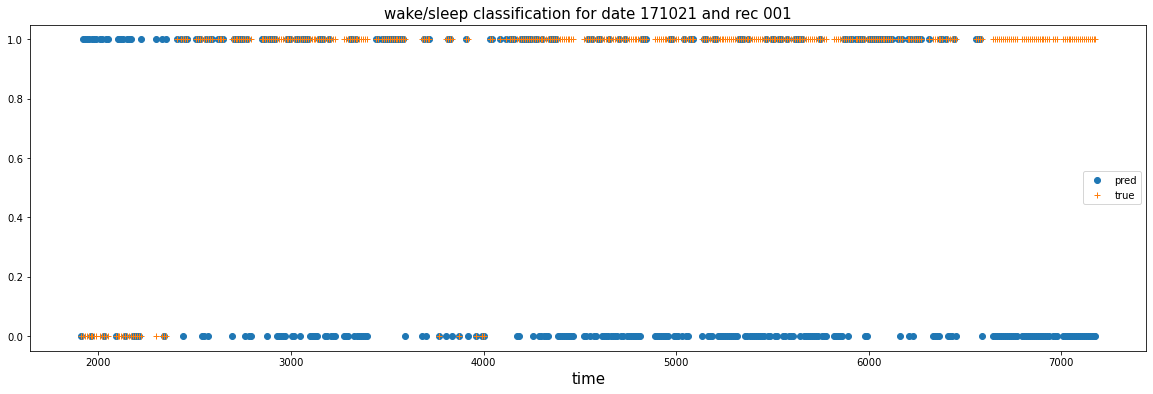

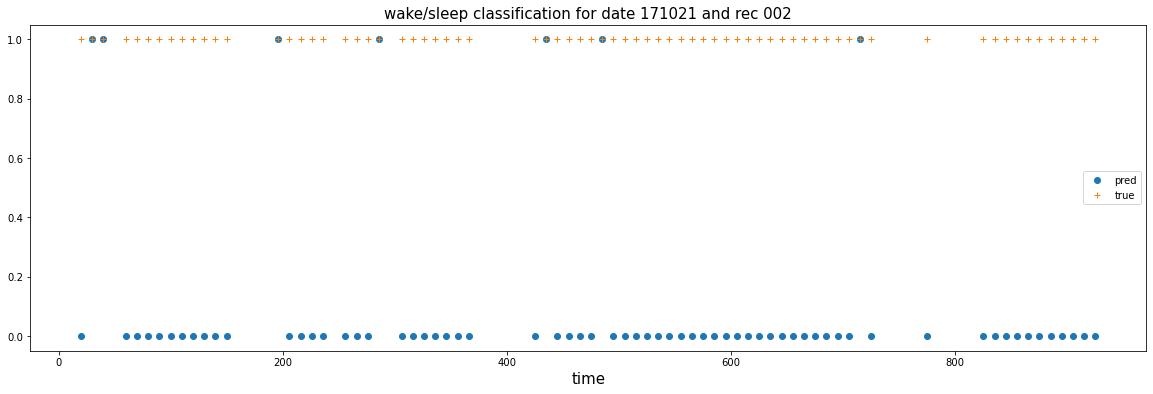

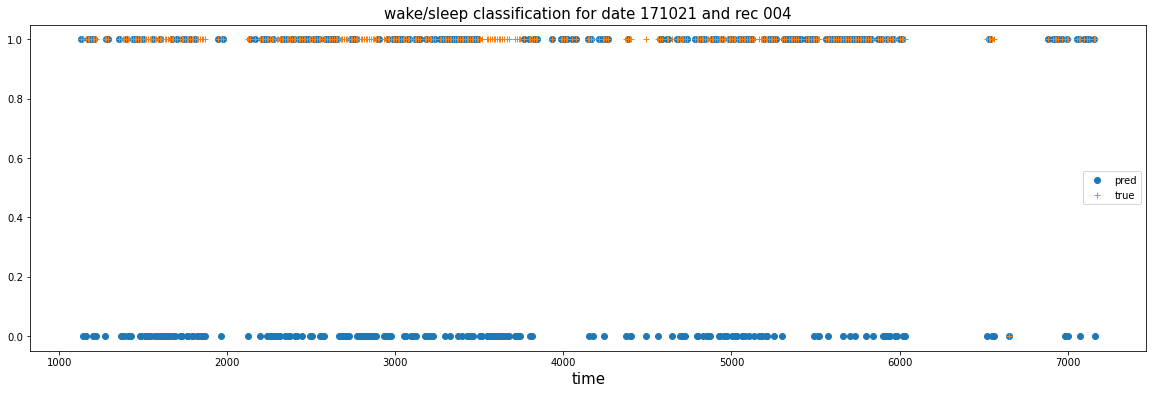

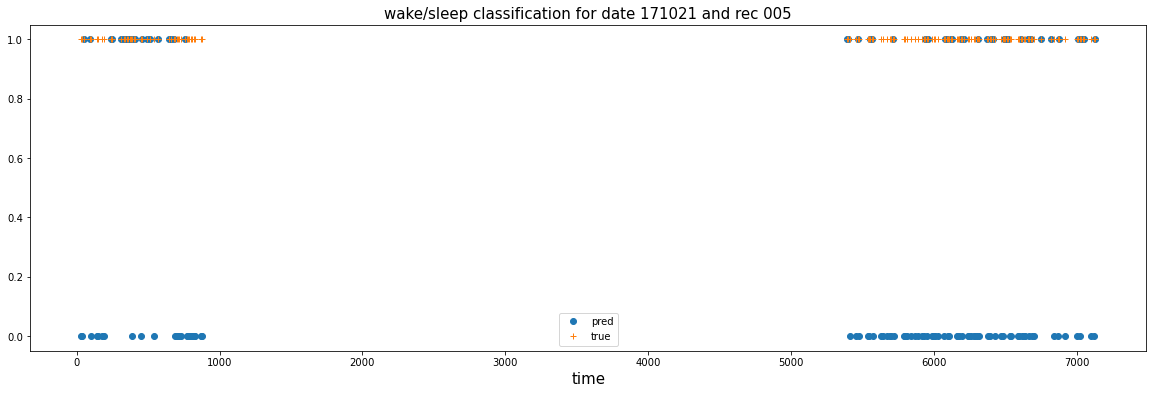

In [6]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.2293280065059662, train accuracy:0.9395254448954106, train percentage postive:0.5


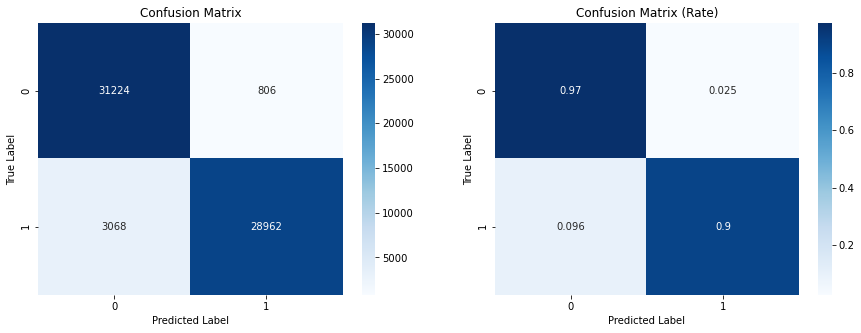

In [7]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 0.7044817209243774
Val loss for epoch 0: 1.3929377794265747
1
Train loss for epoch 1: 0.5390658974647522
Val loss for epoch 1: 1.3496298789978027
2
Train loss for epoch 2: 0.5492311120033264
Val loss for epoch 2: 1.2458561658859253


0
Train loss for epoch 0: 0.8623068928718567
Val loss for epoch 0: 0.813447117805481
1
Train loss for epoch 1: 0.7052937150001526
Val loss for epoch 1: 0.7597342133522034
5
Train loss for epoch 5: 0.719393789768219
Val loss for epoch 5: 0.7586929798126221
7
Train loss for epoch 7: 0.75064617395401
Val loss for epoch 7: 0.6888898015022278
12
Train loss for epoch 12: 0.6320508718490601
Val loss for epoch 12: 0.6481564044952393
15
Train loss for epoch 15: 0.7559710741043091
Val loss for epoch 15: 0.5900769233703613


0
Train loss for epoch 0: 0.8916236162185669
Val loss for epoch 0: 1.340797781944275
1
Train loss for epoch 1: 0.7691159248352051
Val loss for epoch 1: 0.894912600517273
2
Train loss for epoch 2: 0.7486736178398132
Val loss for epoch 2: 0.8034629821777344
6
Train loss for epoch 6: 0.7531395554542542
Val loss for epoch 6: 0.7153528332710266
8
Train loss for epoch 8: 0.7900054454803467
Val loss for epoch 8: 0.6891683340072632
11
Train loss for epoch 11: 0.7711458206176758
Val loss for epoch 11: 0.6768603324890137
12
Train loss for epoch 12: 0.7527375817298889
Val loss for epoch 12: 0.6026954054832458
41
Train loss for epoch 41: 0.7194339036941528
Val loss for epoch 41: 0.556064784526825


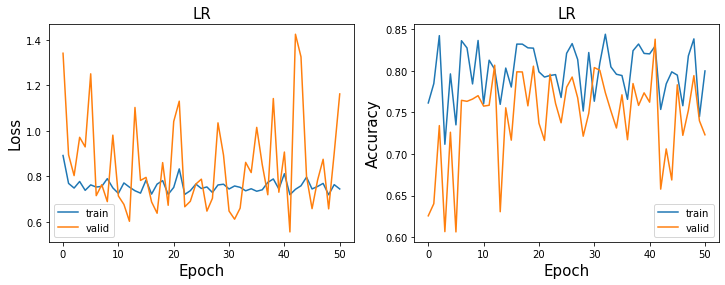

In [9]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.556064784526825, val accuracy:0.8379158180583842, val percentage postive:0.8616768717765808


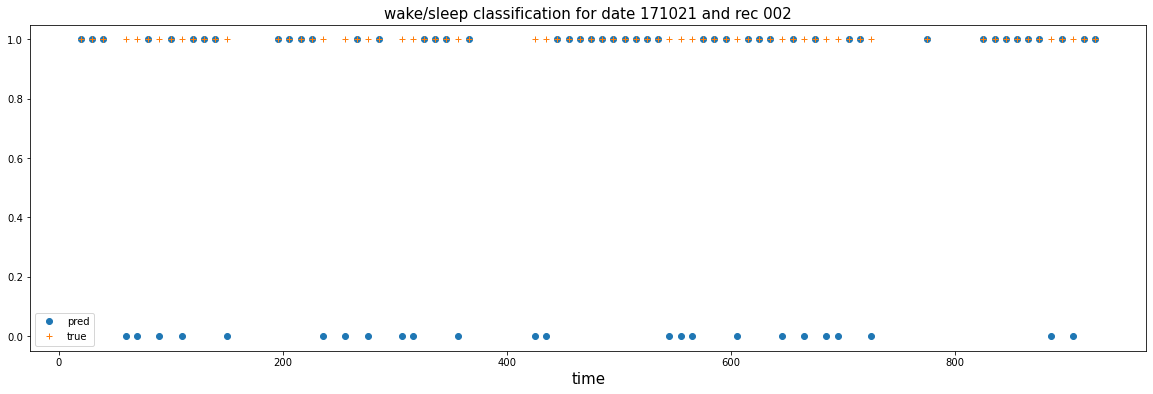

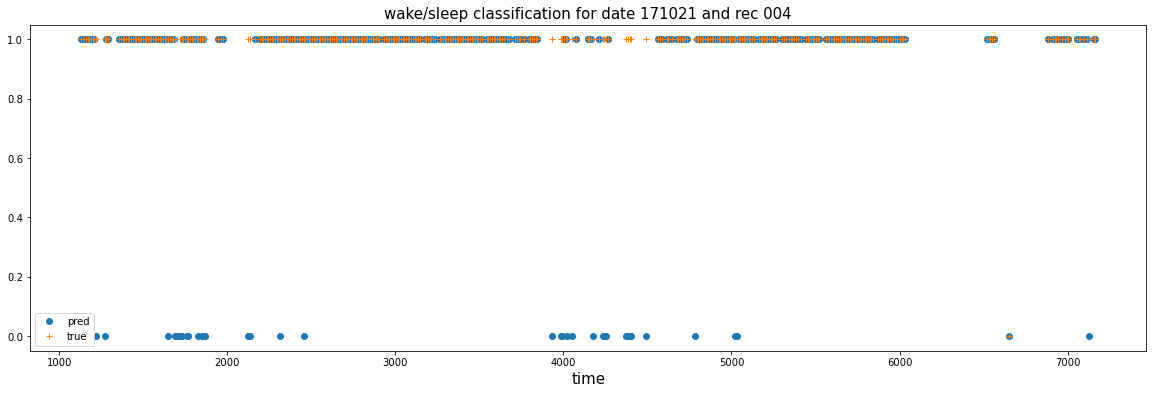

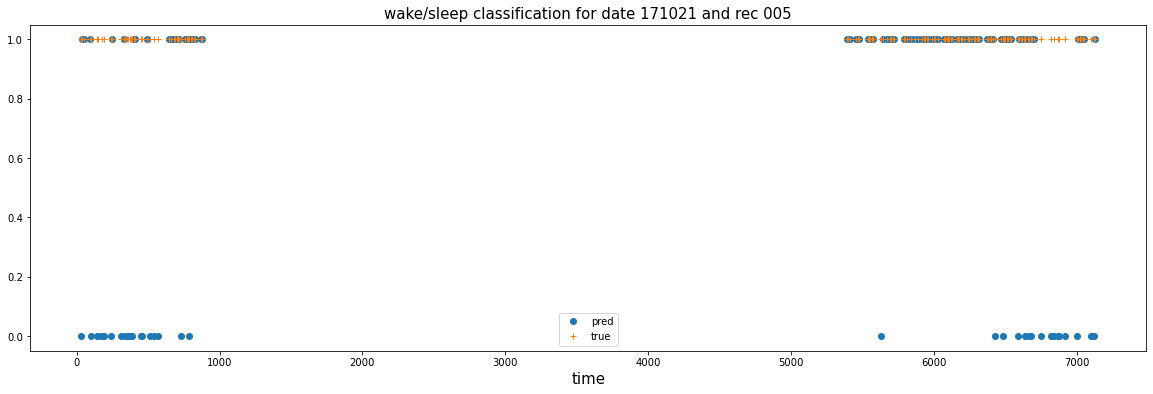

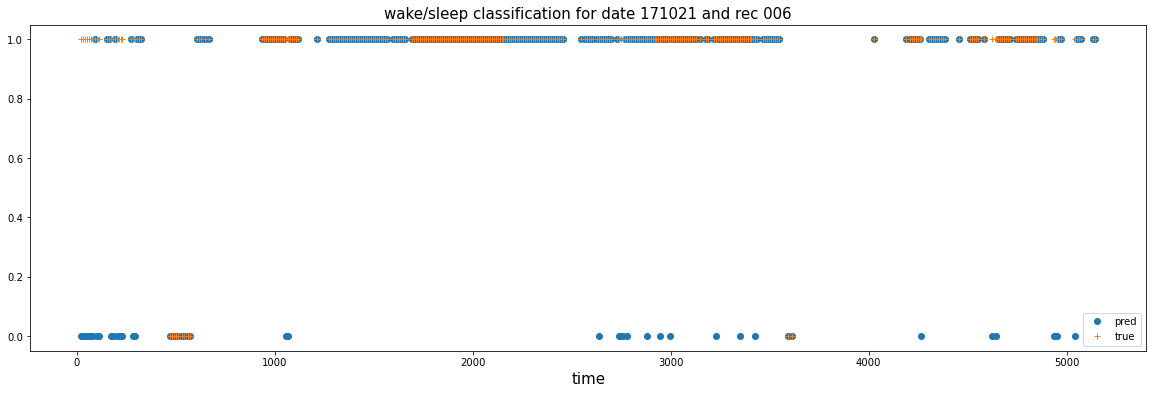

In [10]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:1.0082377195358276, train accuracy:0.7987823915079613, train percentage postive:0.5


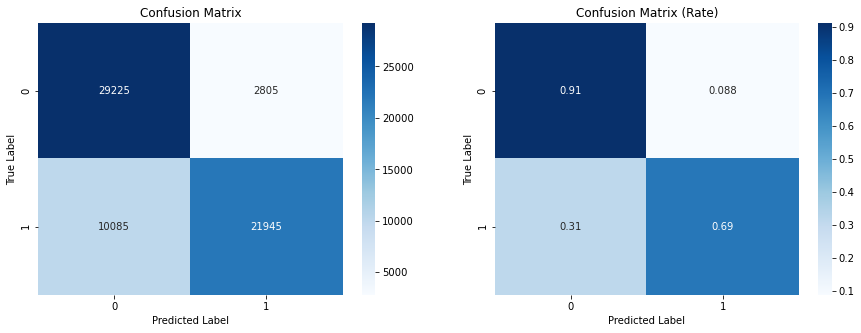

In [5]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'
time_window = 10

0
Train loss for epoch 0: 0.7152011394500732
Val loss for epoch 0: 1.187501311302185


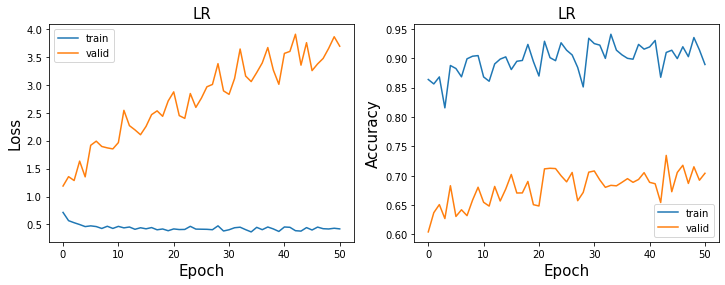

0
Train loss for epoch 0: 0.7333484292030334
Val loss for epoch 0: 1.0648027658462524


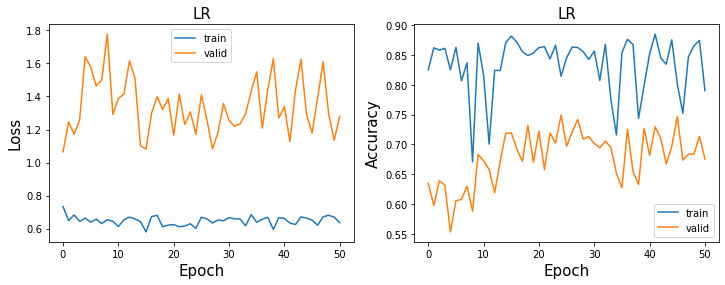

0
Train loss for epoch 0: 0.8584505915641785
Val loss for epoch 0: 1.161240577697754
2
Train loss for epoch 2: 0.7124463319778442
Val loss for epoch 2: 1.1516408920288086
4
Train loss for epoch 4: 0.722143292427063
Val loss for epoch 4: 1.144289493560791
5
Train loss for epoch 5: 0.6058651804924011
Val loss for epoch 5: 1.0008366107940674
11
Train loss for epoch 11: 0.6627742648124695
Val loss for epoch 11: 0.9981367588043213
13
Train loss for epoch 13: 0.7038832306861877
Val loss for epoch 13: 0.9777492880821228
32
Train loss for epoch 32: 0.6972041130065918
Val loss for epoch 32: 0.9713355898857117
42
Train loss for epoch 42: 0.6735908389091492
Val loss for epoch 42: 0.9146397709846497


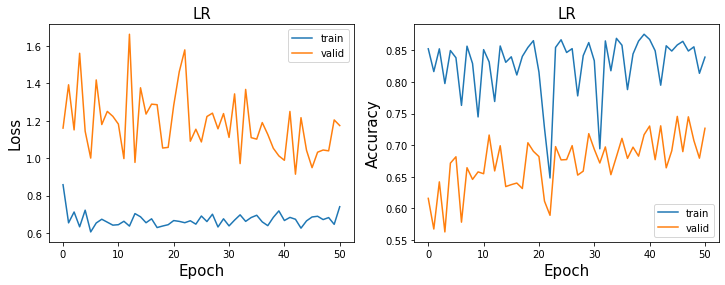

In [4]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.9146397709846497, val accuracy:0.7306517311608961, val percentage postive:0.8616768717765808


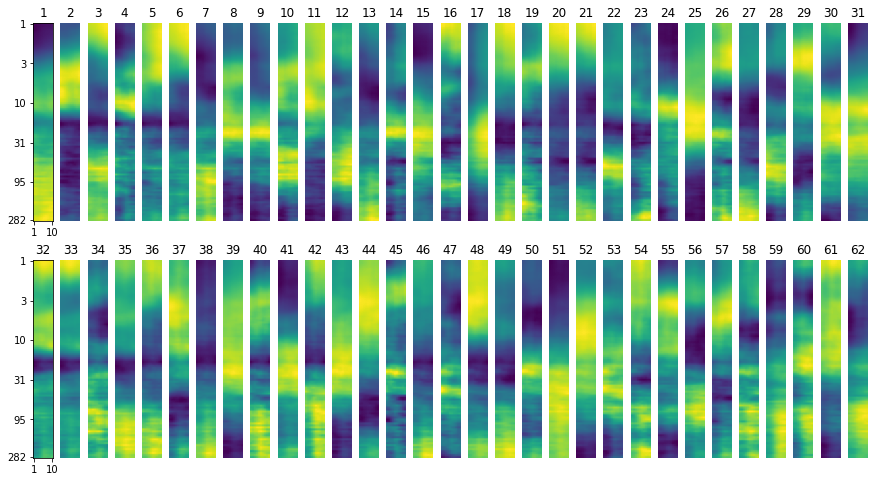

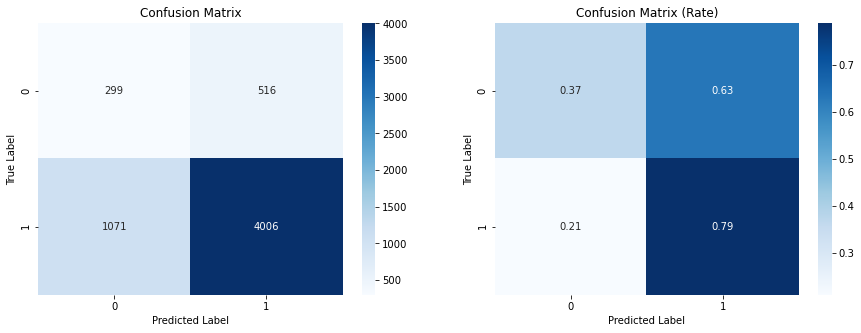

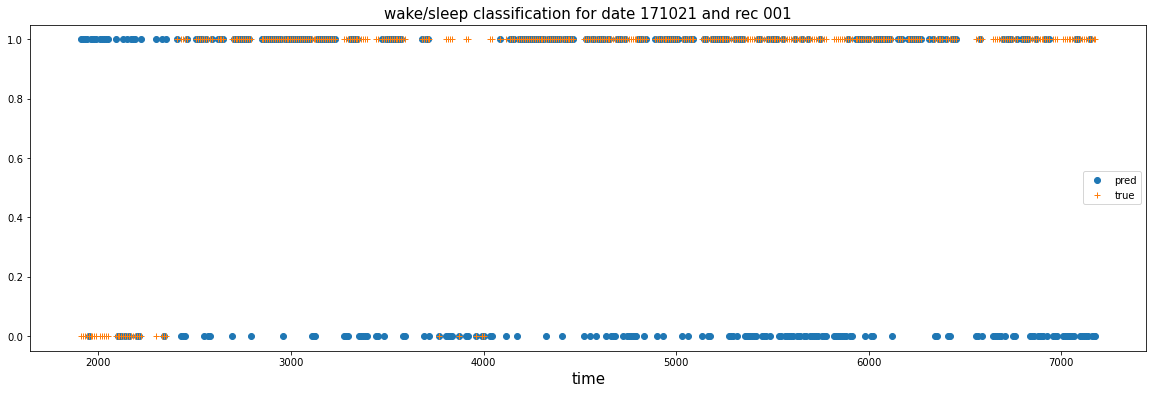

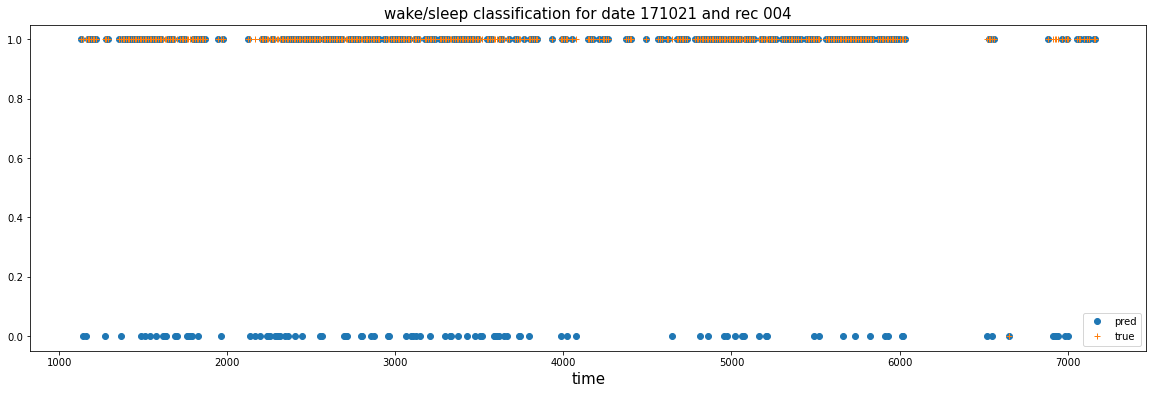

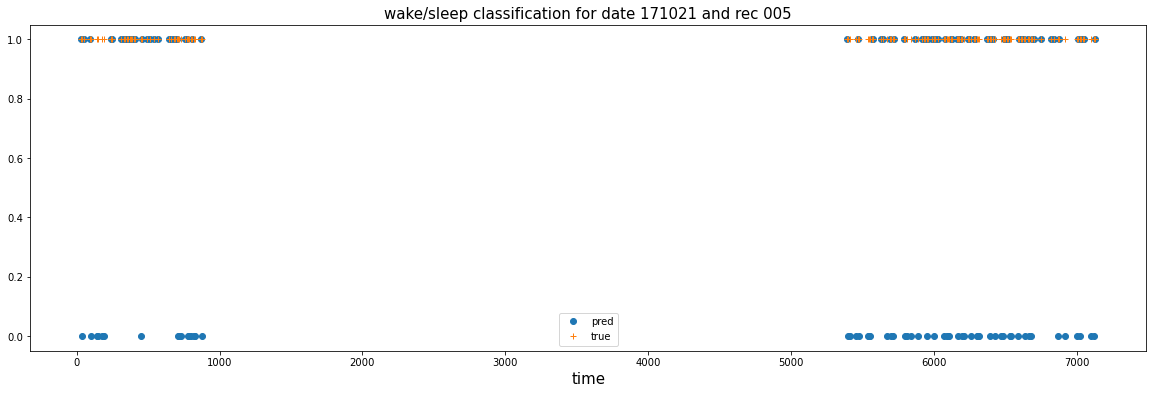

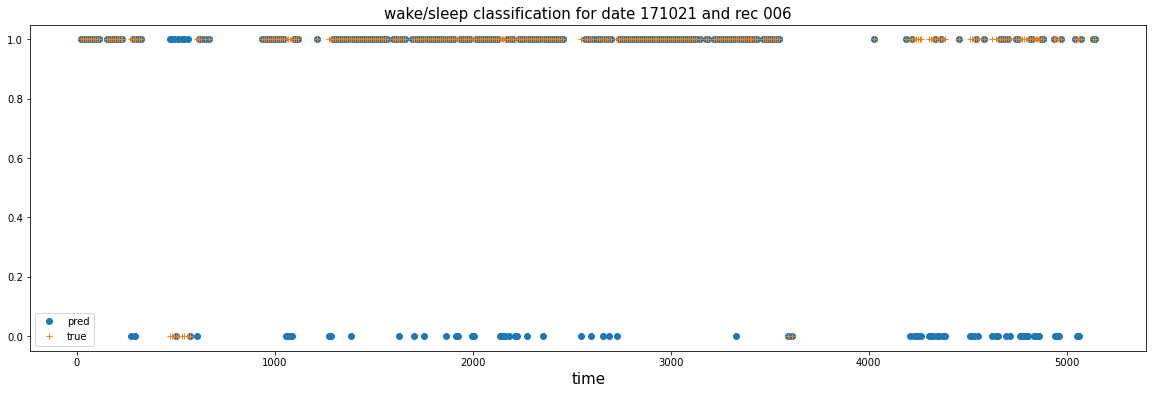

In [5]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

In [4]:
best_alpha = 100

In [5]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

train loss:0.8954030275344849, train accuracy:0.8400561973150171, train percentage postive:0.5


### Fixed Time Window = 10s, Skip Codes Below
### LR, 62CH, 5S

In [14]:
CH = 'all'
time_window = 5
device = torch.device('cuda')

val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_5s_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=128)

val dates: ['180327', '180329'], test dates: ['180330', '180331']
val instances: 13272, val imbalance: 0.7787824273109436
test instances: 13244, test imbalance: 0.7352763414382935
train instances: 41068, train imbalance: 0.5


#### Without regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM(input_dim=100*time_window*62).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [62]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

0
Train loss for epoch 0: 0.5049217343330383
Val loss for epoch 0: 0.45709455013275146


val loss:0.45709455013275146, val accuracy:0.8166817359855335, val percentage postive:0.7787824273109436


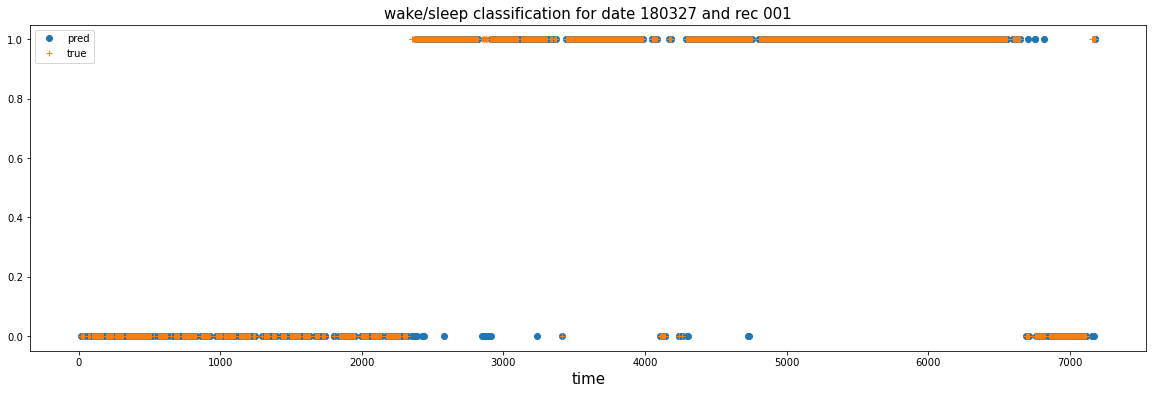

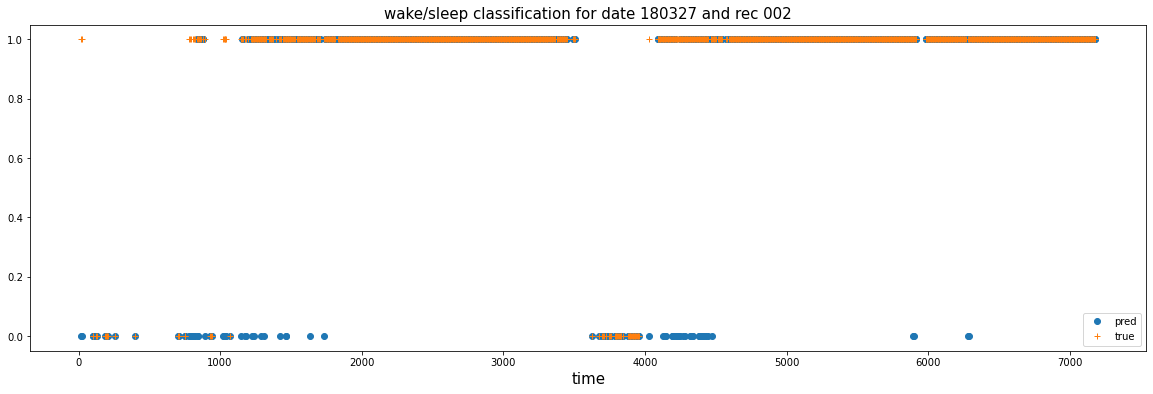

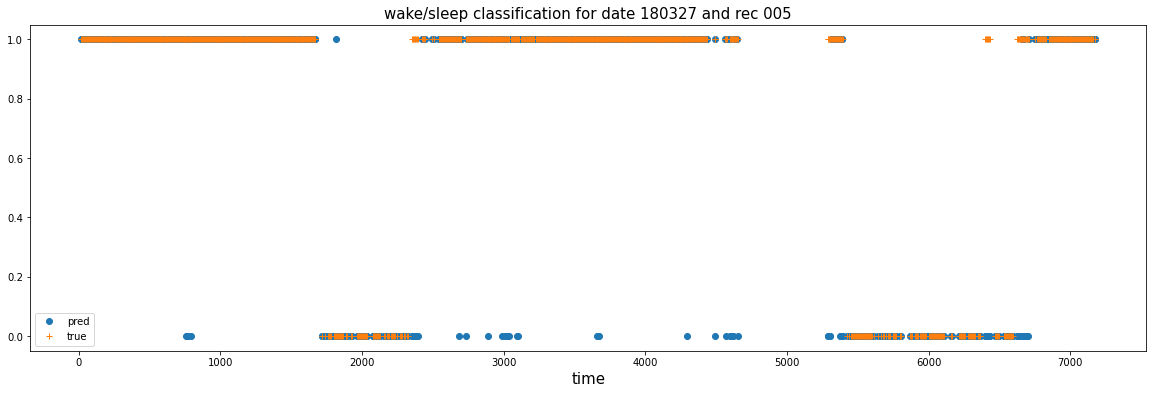

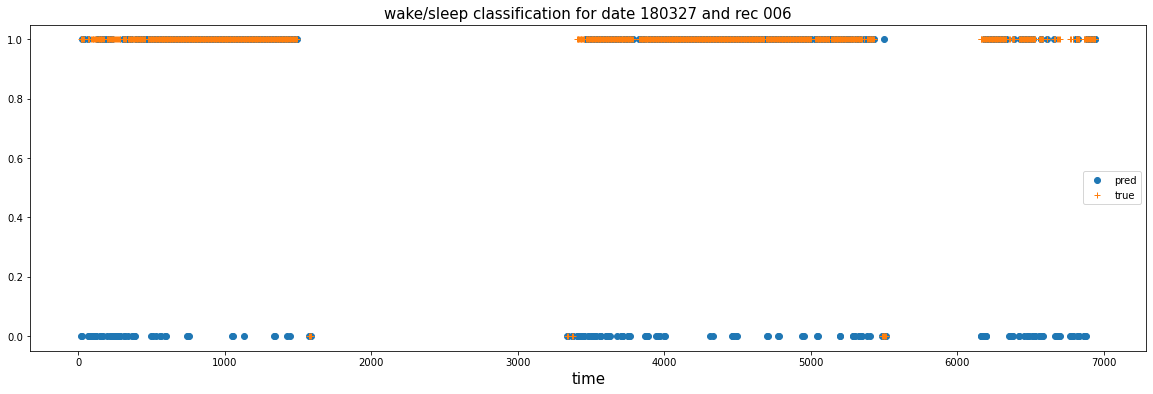

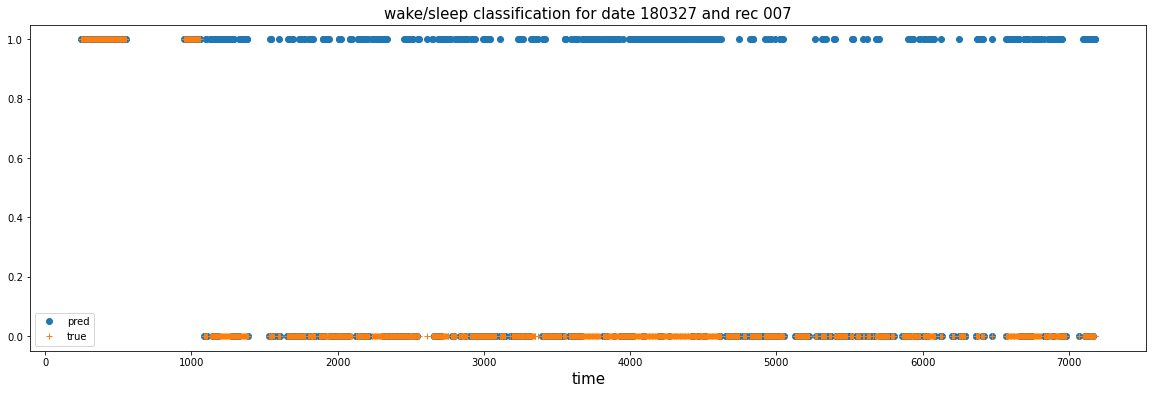

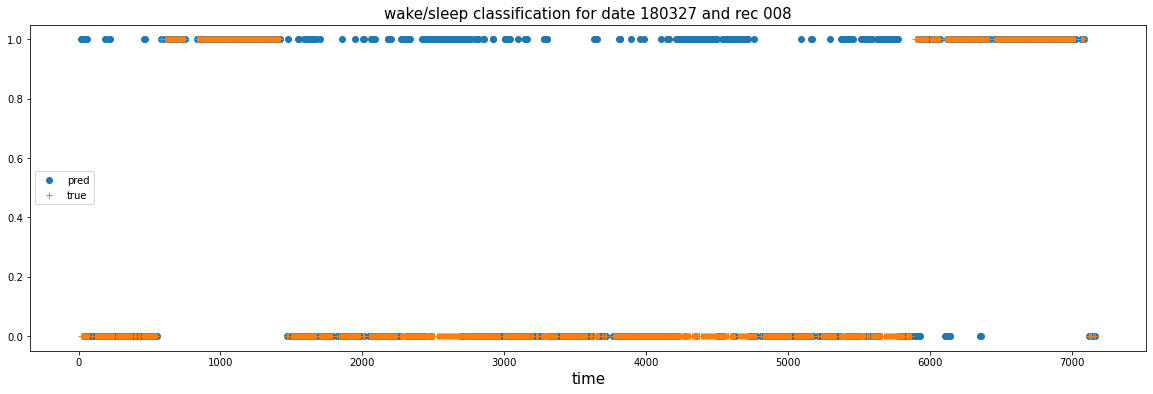

In [5]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.08807075023651123, train accuracy:0.9798870166553034, train percentage postive:0.5


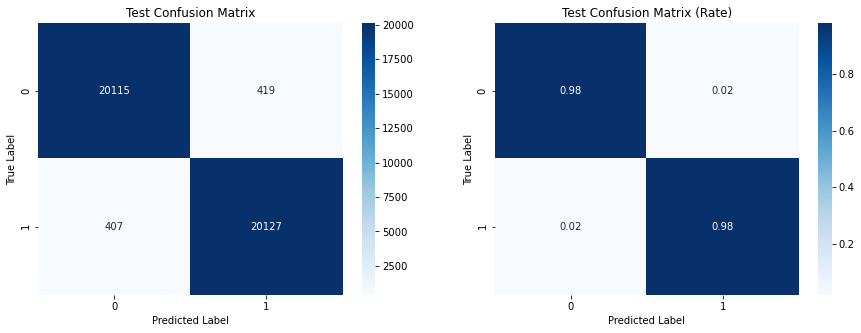

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [7]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 0.5082836151123047
Val loss for epoch 0: 0.5350350737571716
2
Train loss for epoch 2: 0.329218327999115
Val loss for epoch 2: 0.5083081126213074
3
Train loss for epoch 3: 0.32624271512031555
Val loss for epoch 3: 0.492893248796463


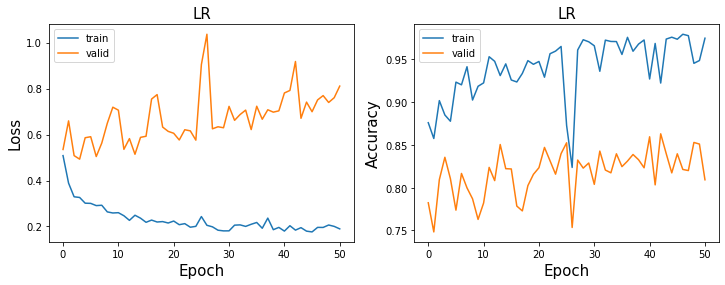

0
Train loss for epoch 0: 0.6597583889961243
Val loss for epoch 0: 0.7763242125511169
1
Train loss for epoch 1: 0.6025110483169556
Val loss for epoch 1: 0.5766419172286987
2
Train loss for epoch 2: 0.5571439266204834
Val loss for epoch 2: 0.5036622285842896
5
Train loss for epoch 5: 0.5644950866699219
Val loss for epoch 5: 0.4759393036365509
9
Train loss for epoch 9: 0.5725904107093811
Val loss for epoch 9: 0.4668348431587219
19
Train loss for epoch 19: 0.5479883551597595
Val loss for epoch 19: 0.4520978033542633
29
Train loss for epoch 29: 0.5671103596687317
Val loss for epoch 29: 0.4517136812210083


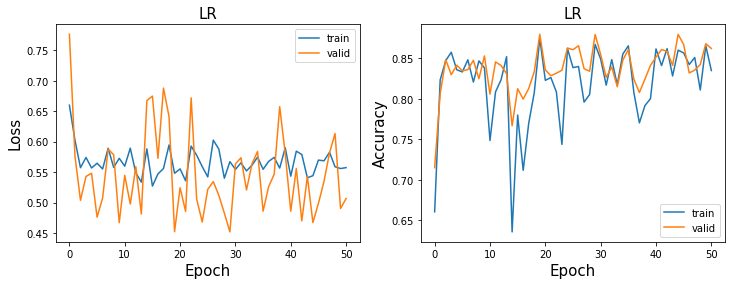

0
Train loss for epoch 0: 0.725829541683197
Val loss for epoch 0: 0.6109916567802429
1
Train loss for epoch 1: 0.6394141912460327
Val loss for epoch 1: 0.5607039928436279
3
Train loss for epoch 3: 0.6107273101806641
Val loss for epoch 3: 0.5351472496986389
5
Train loss for epoch 5: 0.6069586277008057
Val loss for epoch 5: 0.5004533529281616
8
Train loss for epoch 8: 0.6226311326026917
Val loss for epoch 8: 0.49927353858947754
11
Train loss for epoch 11: 0.6038218140602112
Val loss for epoch 11: 0.4832307696342468
20
Train loss for epoch 20: 0.6149115562438965
Val loss for epoch 20: 0.4650472402572632


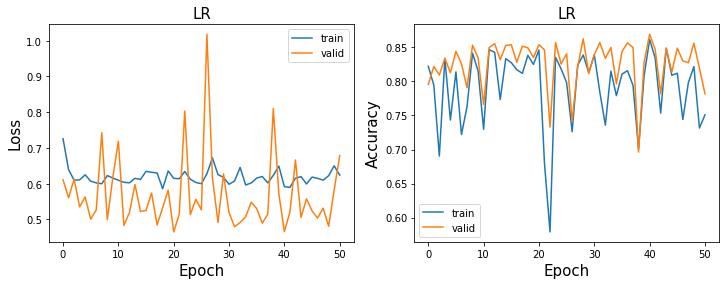

In [8]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.4517136812210083, val accuracy:0.8793701024713683, val percentage postive:0.7787824273109436


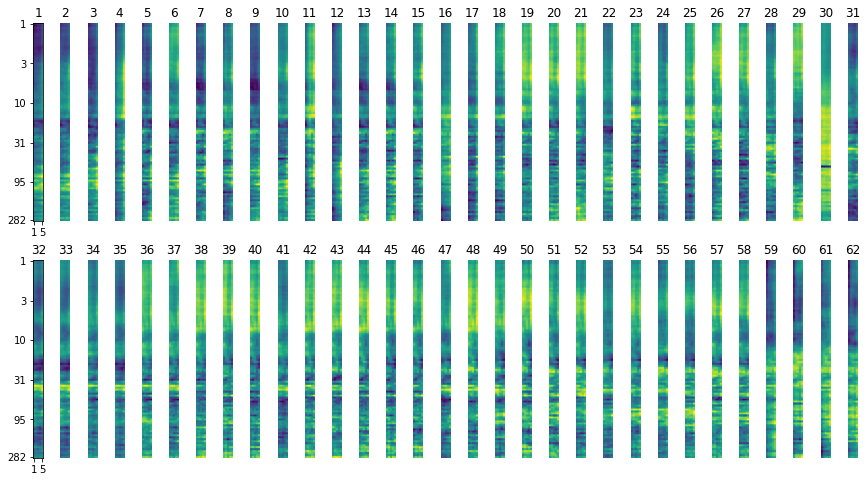

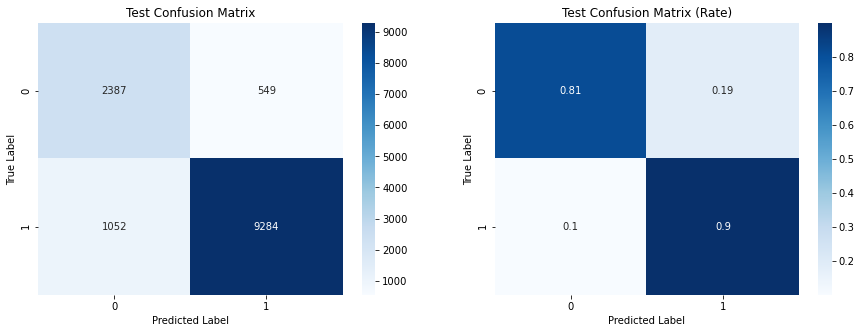

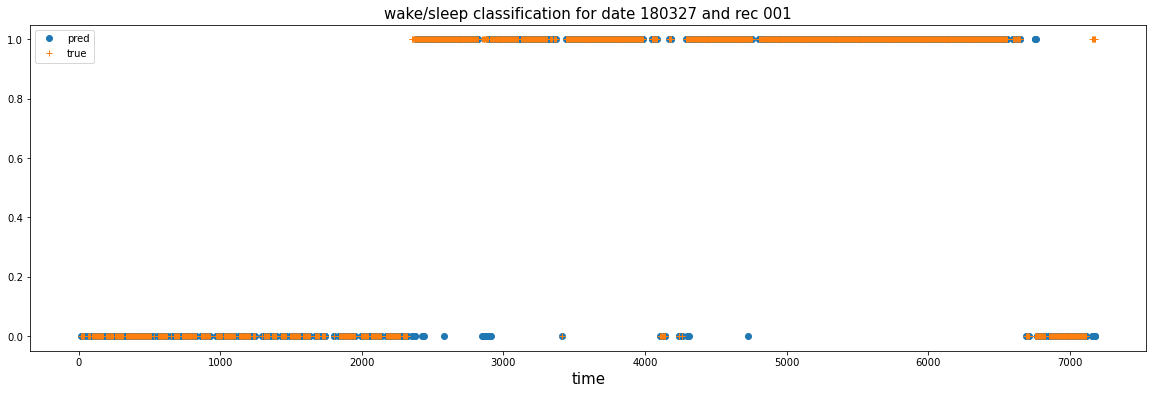

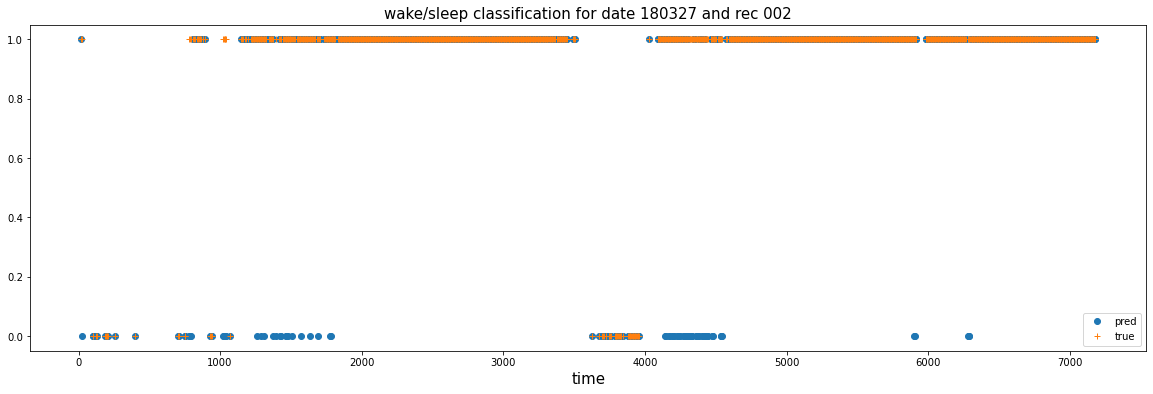

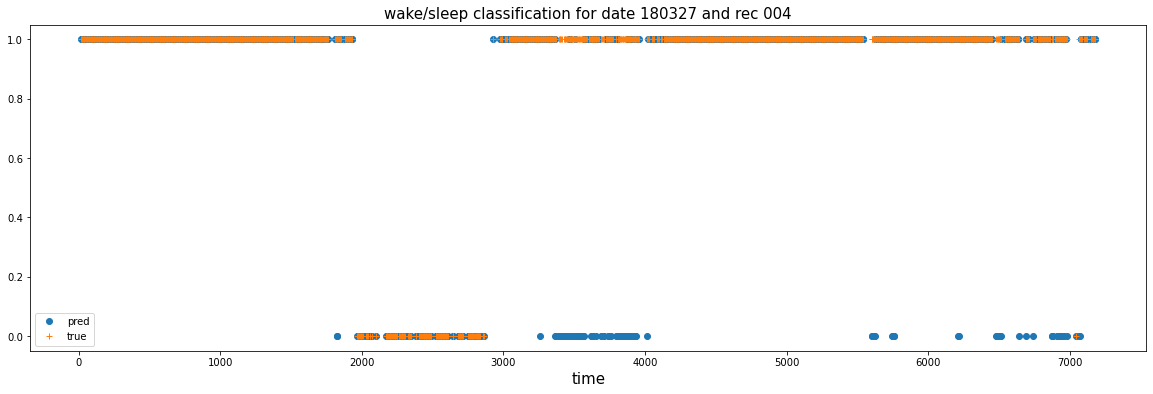

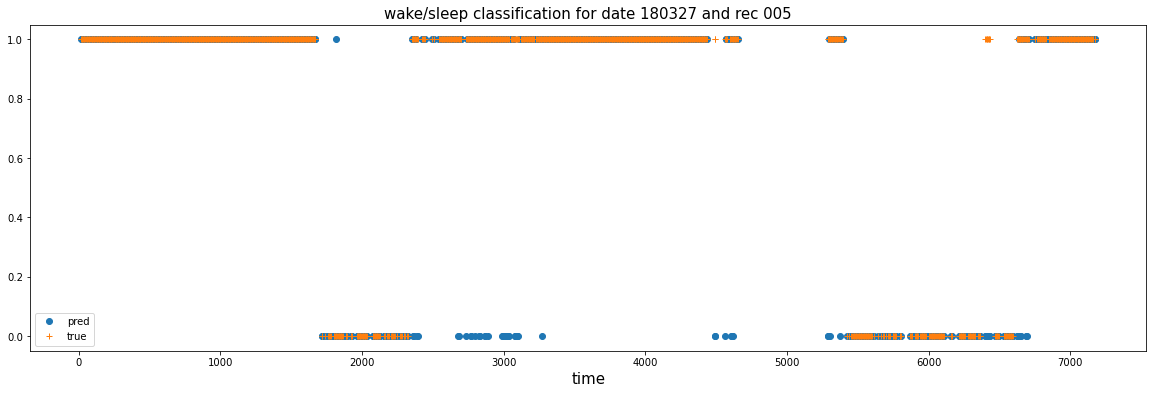

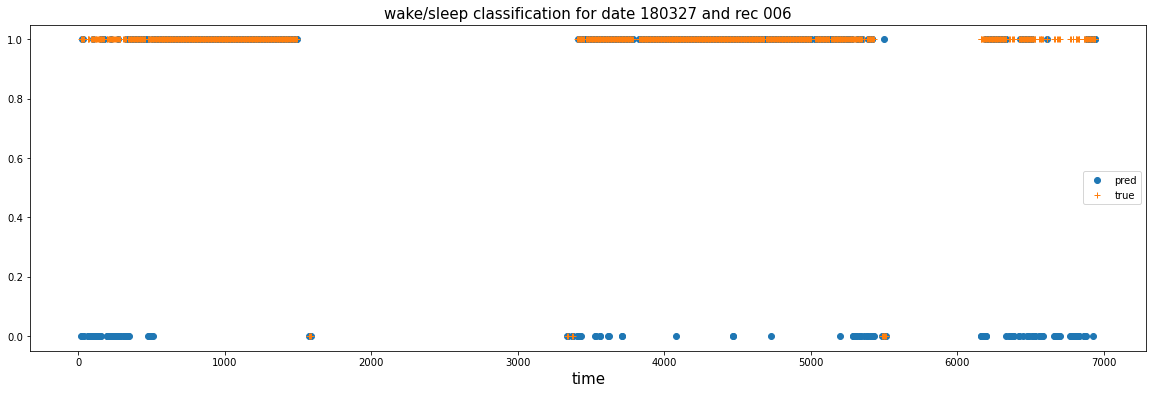

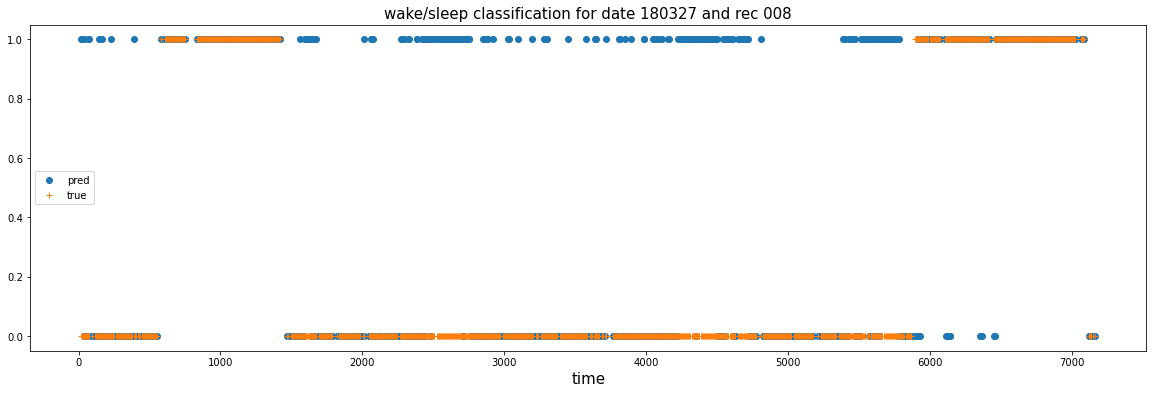

In [9]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.736582338809967, train accuracy:0.7508522450569787, train percentage postive:0.5


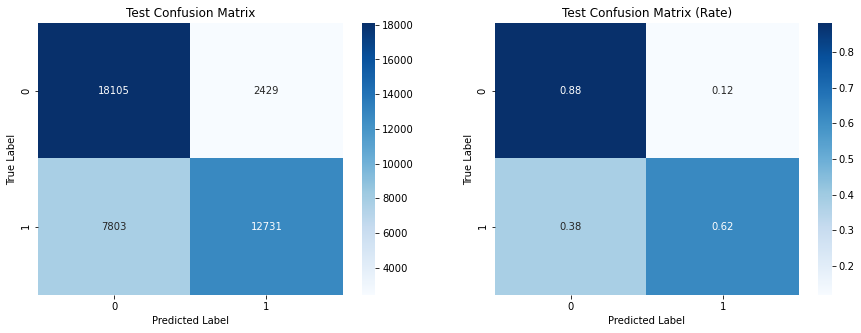

In [10]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'

0
Train loss for epoch 0: 0.4929482340812683
Val loss for epoch 0: 0.4725939929485321


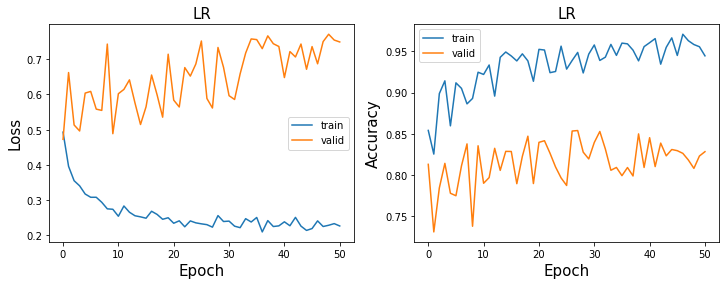

0
Train loss for epoch 0: 0.5969903469085693
Val loss for epoch 0: 0.5214177966117859
1
Train loss for epoch 1: 0.49316632747650146
Val loss for epoch 1: 0.48322010040283203
5
Train loss for epoch 5: 0.45493564009666443
Val loss for epoch 5: 0.4556831419467926
8
Train loss for epoch 8: 0.4385402798652649
Val loss for epoch 8: 0.4491444230079651
23
Train loss for epoch 23: 0.4720892906188965
Val loss for epoch 23: 0.4332025647163391


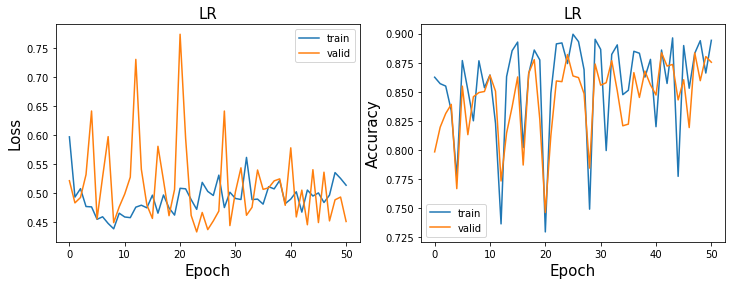

0
Train loss for epoch 0: 0.6056838631629944
Val loss for epoch 0: 0.5279271006584167
1
Train loss for epoch 1: 0.49098891019821167
Val loss for epoch 1: 0.504608690738678
4
Train loss for epoch 4: 0.517510175704956
Val loss for epoch 4: 0.47482648491859436
11
Train loss for epoch 11: 0.5076421499252319
Val loss for epoch 11: 0.4738823175430298
13
Train loss for epoch 13: 0.4973599314689636
Val loss for epoch 13: 0.4289557635784149
15
Train loss for epoch 15: 0.4899548590183258
Val loss for epoch 15: 0.42891696095466614
33
Train loss for epoch 33: 0.5387601852416992
Val loss for epoch 33: 0.42052894830703735


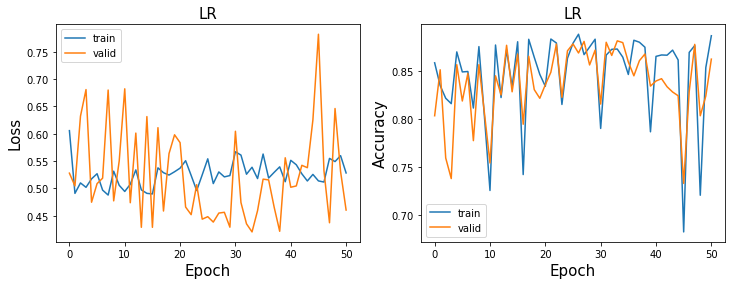

In [4]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.42052894830703735, val accuracy:0.88208257986739, val percentage postive:0.7787824273109436


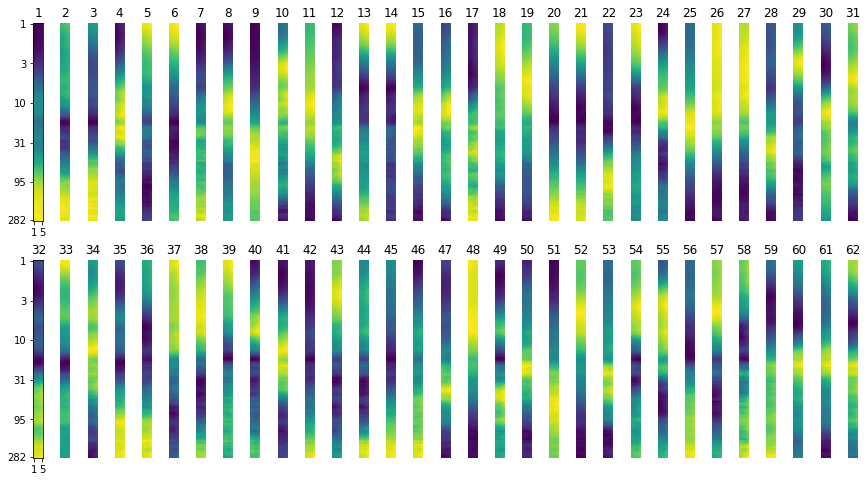

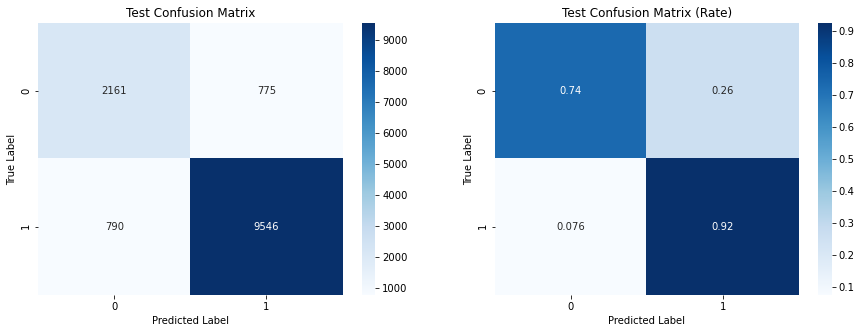

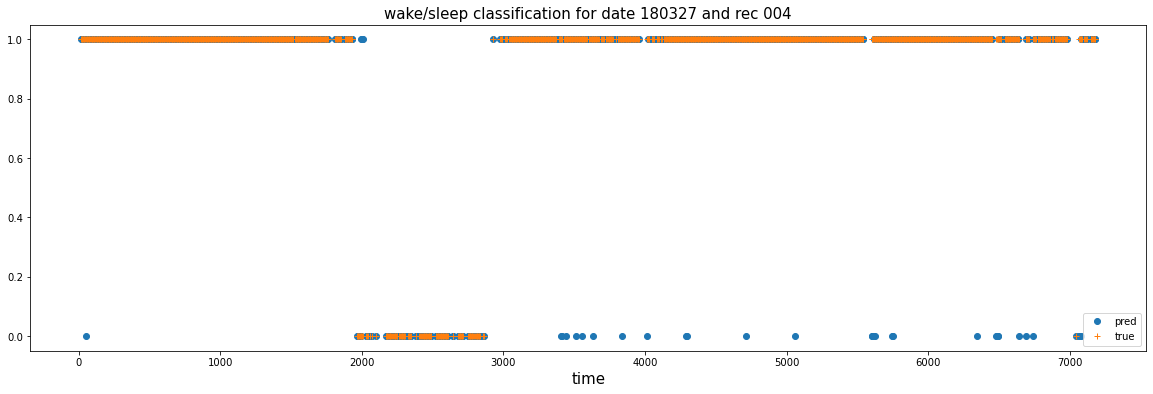

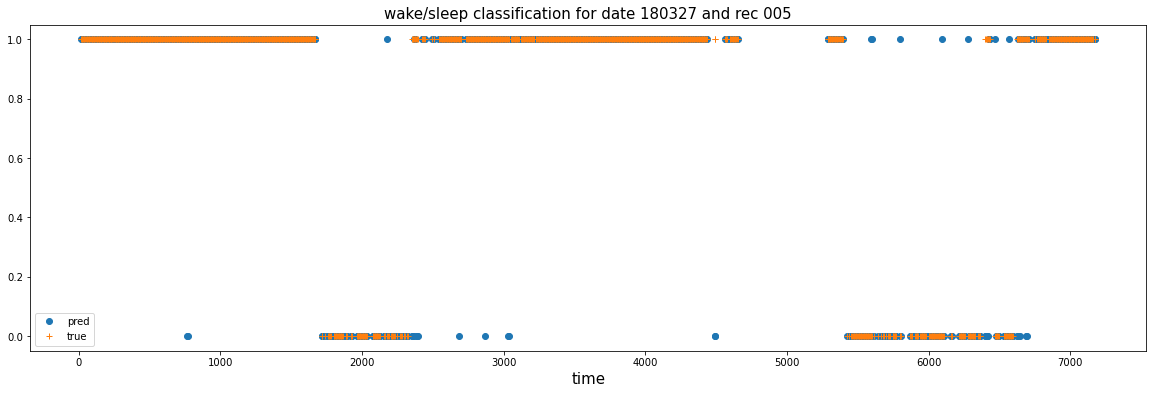

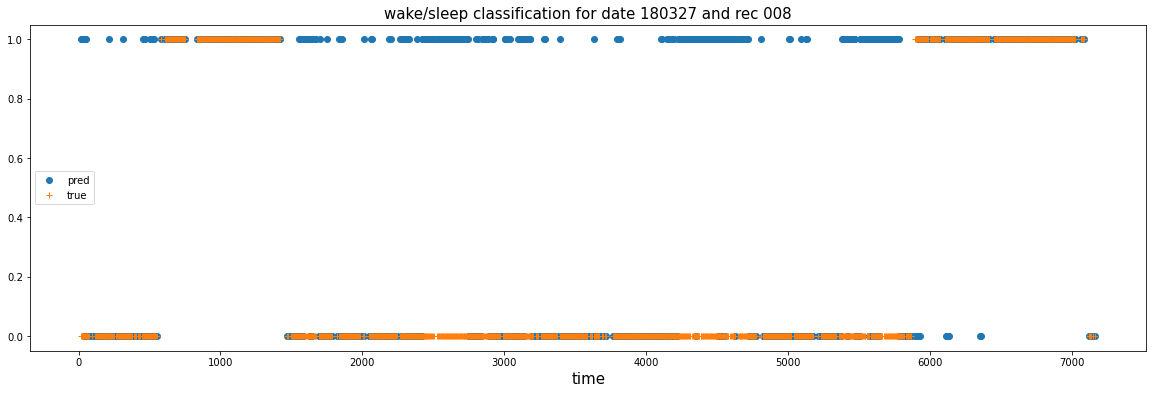

In [5]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

train loss:0.448866605758667, train accuracy:0.8874306029025032, train percentage postive:0.5


### LR, 62CH, 15S

In [2]:
CH = 'all'
time_window = 15
device = torch.device('cuda')

val_dates = ['180327']
test_dates = ['180330']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_15s_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=256)

val dates: ['180327'], test dates: ['180330']
val instances: 807, val imbalance: 0.0768277570605278
test instances: 703, test imbalance: 0.10953058302402496
train instances: 2934, train imbalance: 0.5


In [41]:
# CH = 'all'
# time_window = 15
# device = torch.device('cuda')

# val_dates = ['180324', '180330']
# test_dates = ['180325', '180327']
# bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
# load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_15s_2/'
# save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

# test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
# train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
# train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=256)

#### Without regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM(input_dim=100*time_window*62).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 7.3623785972595215
Val loss for epoch 0: 8.354308128356934
1
Train loss for epoch 1: 8.883780479431152
Val loss for epoch 1: 7.8880205154418945
2
Train loss for epoch 2: 8.040365219116211
Val loss for epoch 2: 7.6427998542785645
3
Train loss for epoch 3: 5.689975261688232
Val loss for epoch 3: 6.753273010253906
4
Train loss for epoch 4: 2.088932514190674
Val loss for epoch 4: 3.512111186981201
7
Train loss for epoch 7: 0.5362054705619812
Val loss for epoch 7: 2.4628188610076904
8
Train loss for epoch 8: 0.4683822989463806
Val loss for epoch 8: 1.9404903650283813
9
Train loss for epoch 9: 0.3243051767349243
Val loss for epoch 9: 1.130286455154419
10
Train loss for epoch 10: 0.2108927220106125
Val loss for epoch 10: 1.0912070274353027
11
Train loss for epoch 11: 0.20146909356117249
Val loss for epoch 11: 0.7431933283805847
18
Train loss for epoch 18: 0.03813327103853226
Val loss for epoch 18: 0.6386033892631531


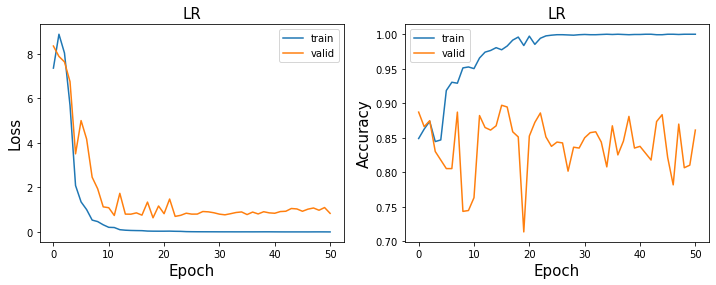

In [4]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

val loss:0.6386033892631531, val accuracy:0.8513011152416357, val percentage postive:0.0768277570605278


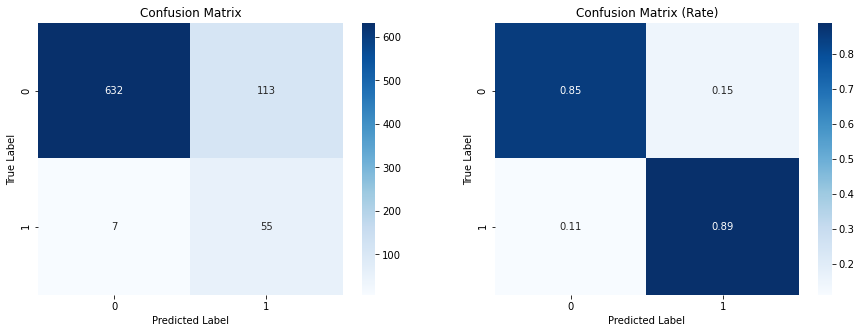

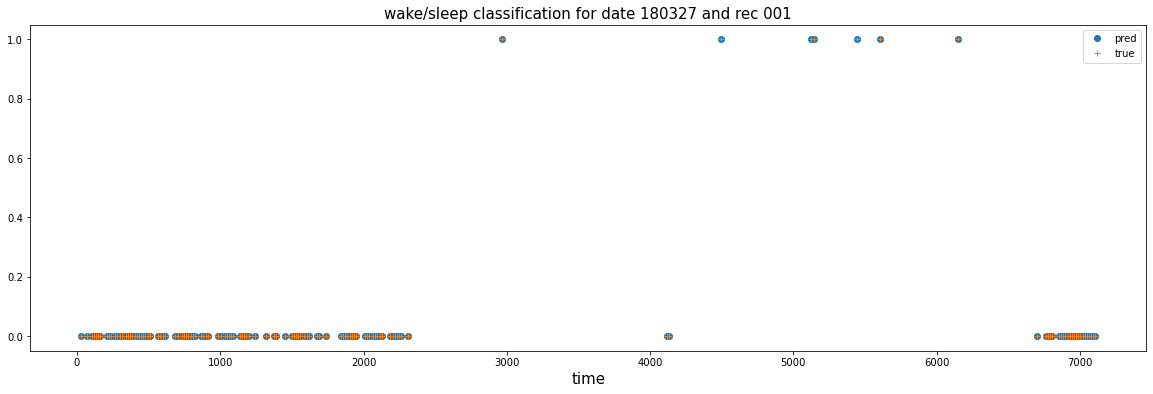

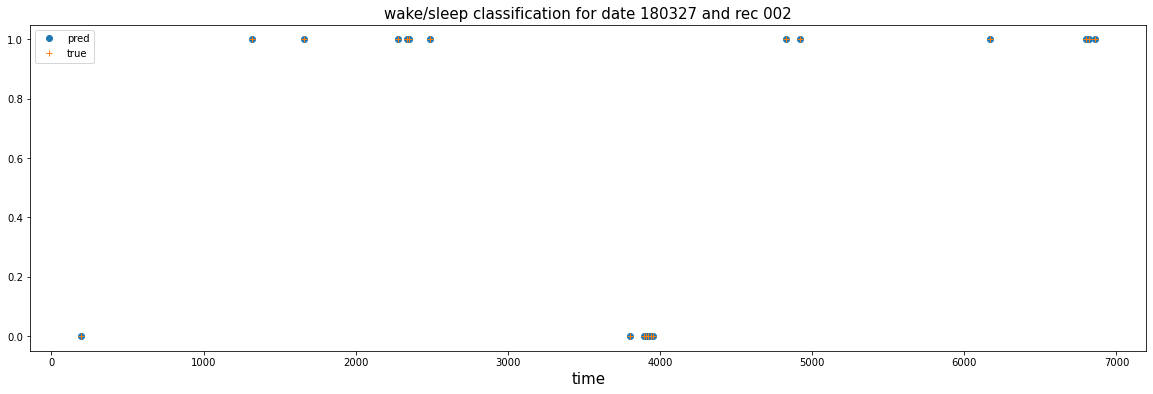

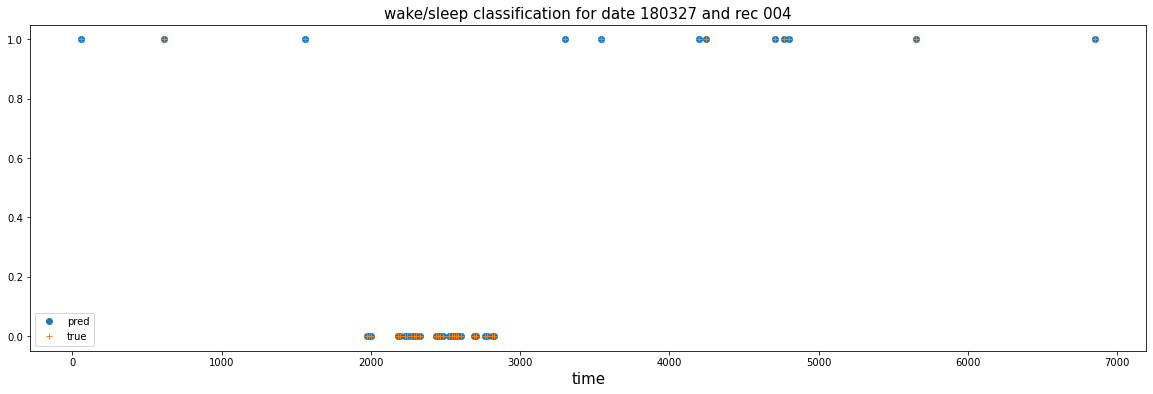

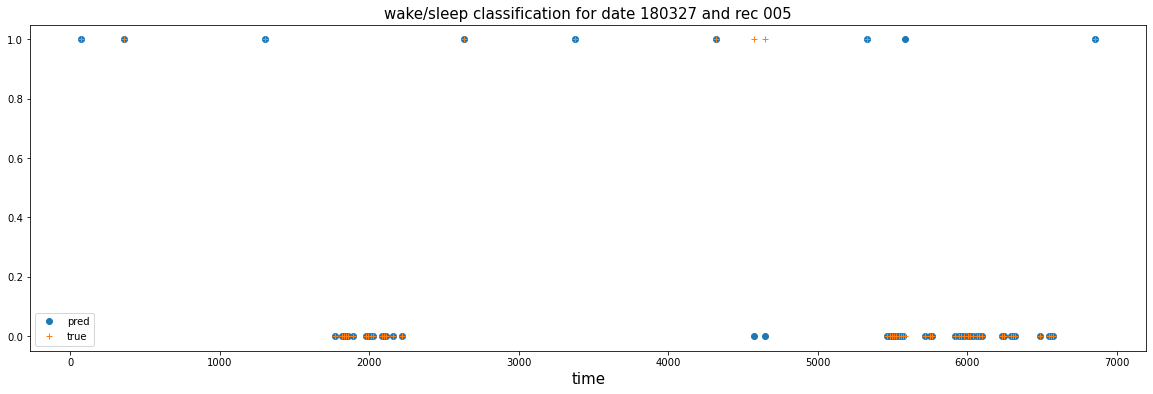

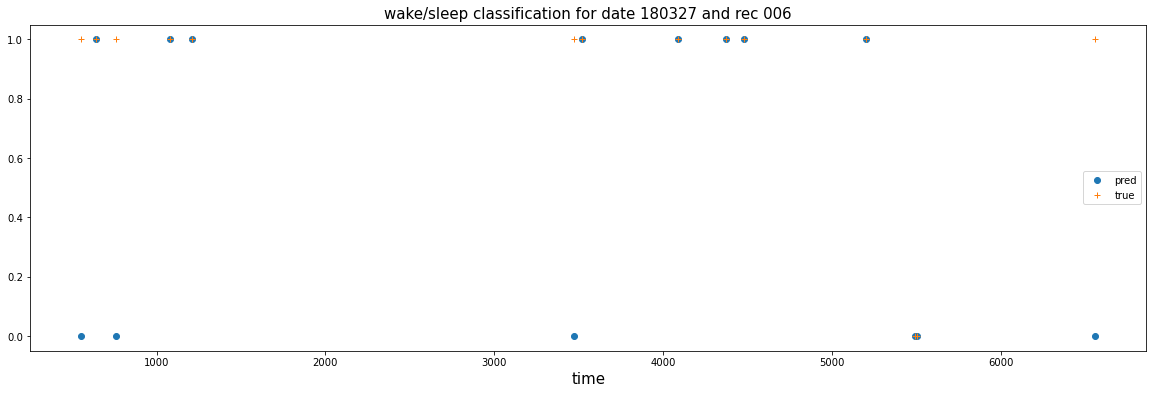

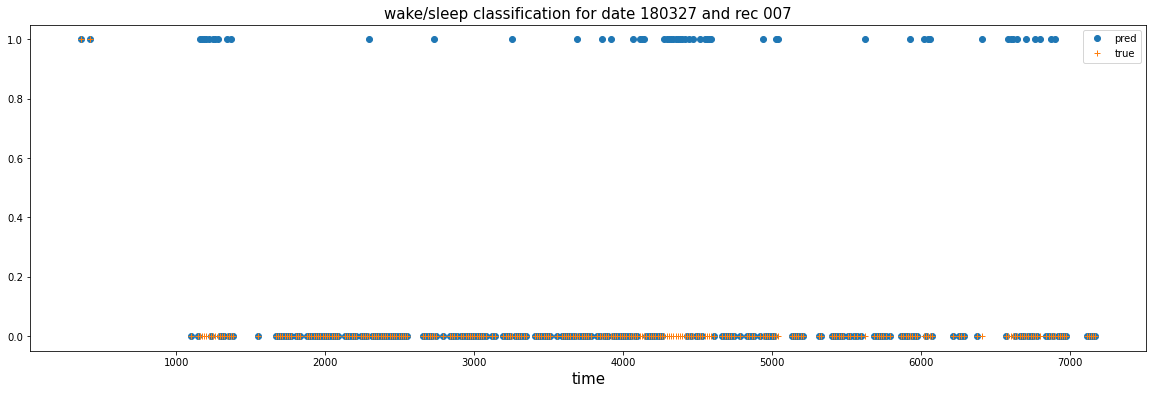

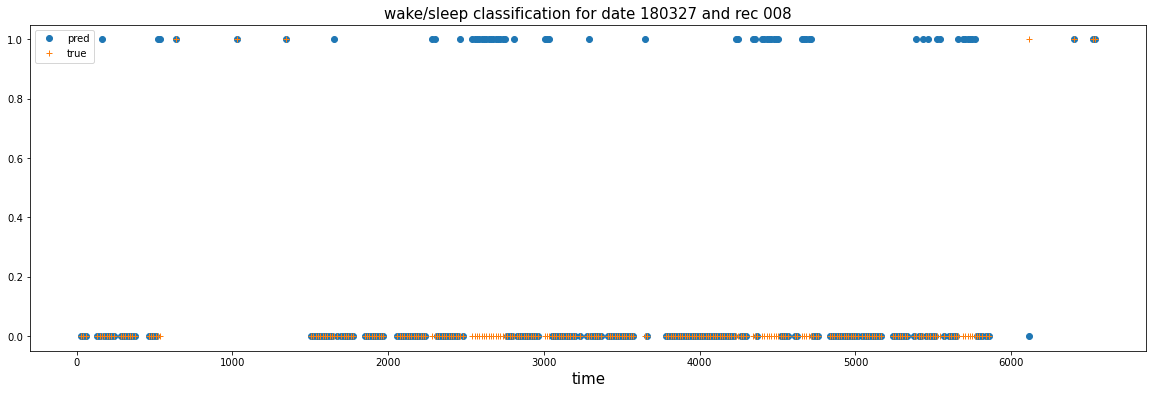

In [5]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.004001283552497625, train accuracy:1.0, train percentage postive:0.5


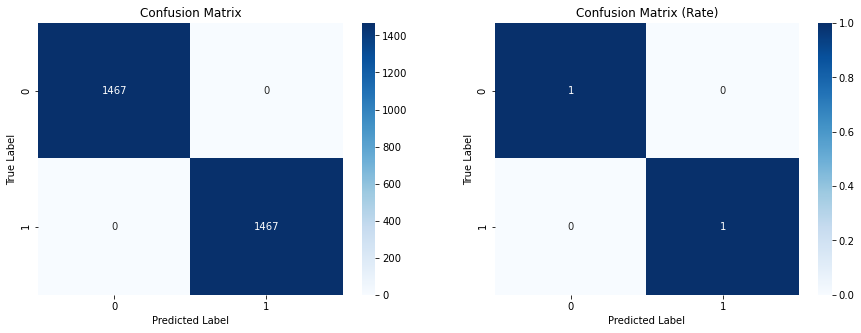

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [7]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 6.742123126983643
Val loss for epoch 0: 7.713152885437012
2
Train loss for epoch 2: 6.552579402923584
Val loss for epoch 2: 7.243968486785889
3
Train loss for epoch 3: 2.52925443649292
Val loss for epoch 3: 4.5471930503845215
5
Train loss for epoch 5: 0.9554158449172974
Val loss for epoch 5: 2.8371403217315674
6
Train loss for epoch 6: 0.47639256715774536
Val loss for epoch 6: 0.8898207545280457
11
Train loss for epoch 11: 0.10406990349292755
Val loss for epoch 11: 0.7101783752441406
24
Train loss for epoch 24: 0.02310832589864731
Val loss for epoch 24: 0.5841119289398193


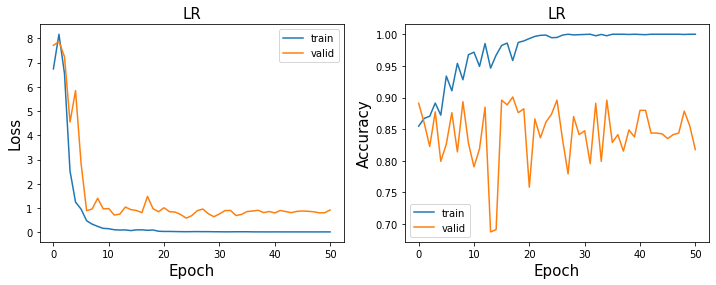

0
Train loss for epoch 0: 8.16971206665039
Val loss for epoch 0: 7.614139556884766
2
Train loss for epoch 2: 8.341407775878906
Val loss for epoch 2: 7.251531600952148
3
Train loss for epoch 3: 5.324763298034668
Val loss for epoch 3: 6.570837020874023
4
Train loss for epoch 4: 1.7969921827316284
Val loss for epoch 4: 5.064217567443848
5
Train loss for epoch 5: 1.516917109489441
Val loss for epoch 5: 2.067976474761963
6
Train loss for epoch 6: 0.7259712219238281
Val loss for epoch 6: 1.6132588386535645
9
Train loss for epoch 9: 0.5211003422737122
Val loss for epoch 9: 1.021061658859253
10
Train loss for epoch 10: 0.40800920128822327
Val loss for epoch 10: 0.885645866394043
12
Train loss for epoch 12: 0.32844215631484985
Val loss for epoch 12: 0.7042562961578369
13
Train loss for epoch 13: 0.32312583923339844
Val loss for epoch 13: 0.6663298010826111
31
Train loss for epoch 31: 0.2851581573486328
Val loss for epoch 31: 0.6294642090797424


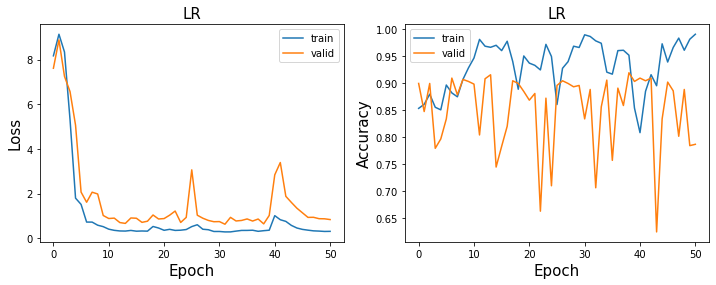

0
Train loss for epoch 0: 6.601210117340088
Val loss for epoch 0: 7.076709270477295
1
Train loss for epoch 1: 5.750747203826904
Val loss for epoch 1: 5.684140205383301
2
Train loss for epoch 2: 2.300185441970825
Val loss for epoch 2: 1.8012913465499878
4
Train loss for epoch 4: 0.975090503692627
Val loss for epoch 4: 1.0536150932312012
5
Train loss for epoch 5: 0.6516616344451904
Val loss for epoch 5: 0.8820650577545166
6
Train loss for epoch 6: 0.5310970544815063
Val loss for epoch 6: 0.8228191137313843
8
Train loss for epoch 8: 0.5179251432418823
Val loss for epoch 8: 0.6811643242835999
18
Train loss for epoch 18: 0.48008403182029724
Val loss for epoch 18: 0.6454691290855408
19
Train loss for epoch 19: 0.4097549319267273
Val loss for epoch 19: 0.6205943822860718
41
Train loss for epoch 41: 0.35477718710899353
Val loss for epoch 41: 0.5697904825210571


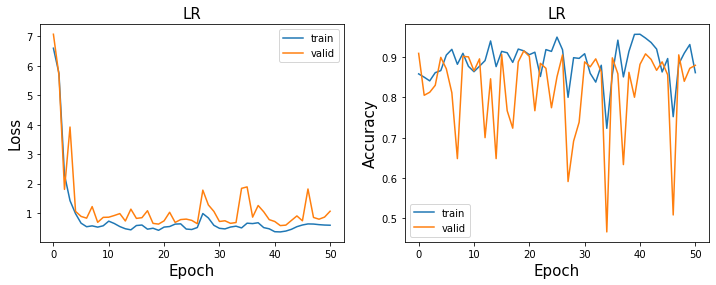

In [8]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.5697904825210571, val accuracy:0.9083023543990086, val percentage postive:0.0768277570605278


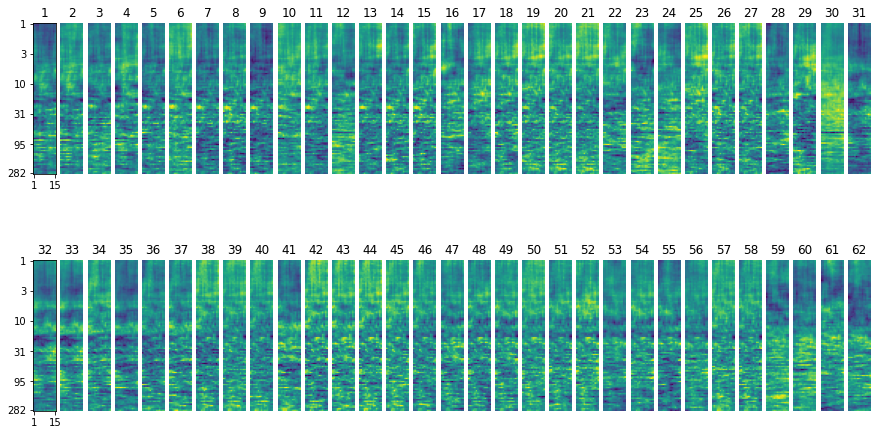

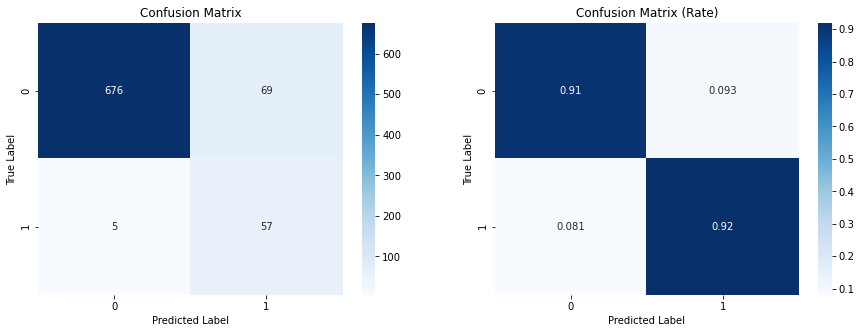

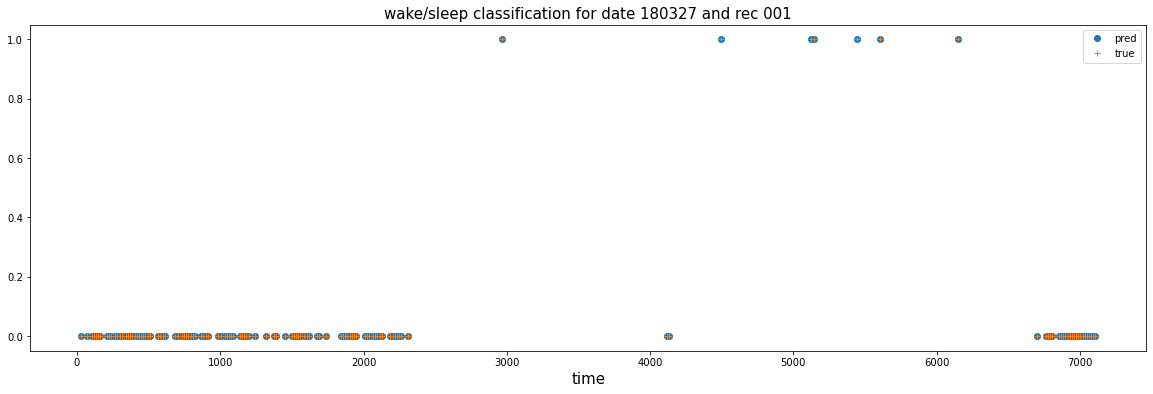

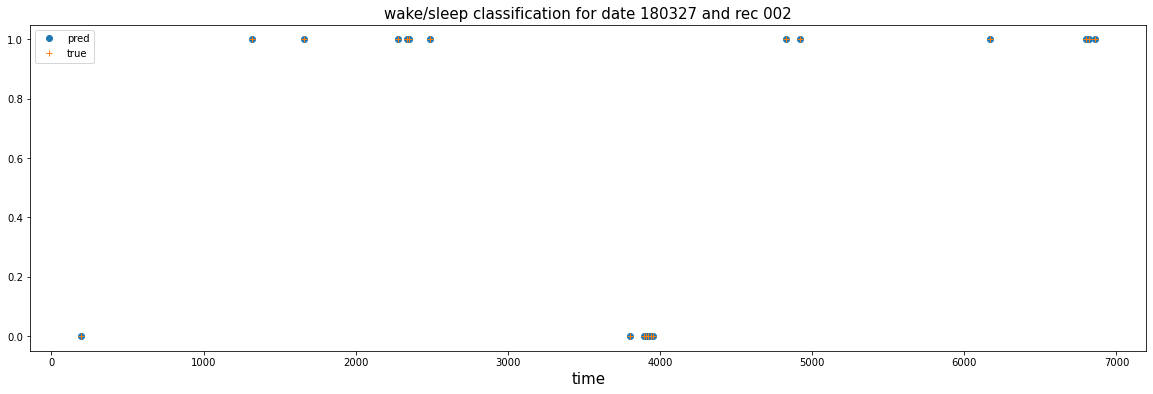

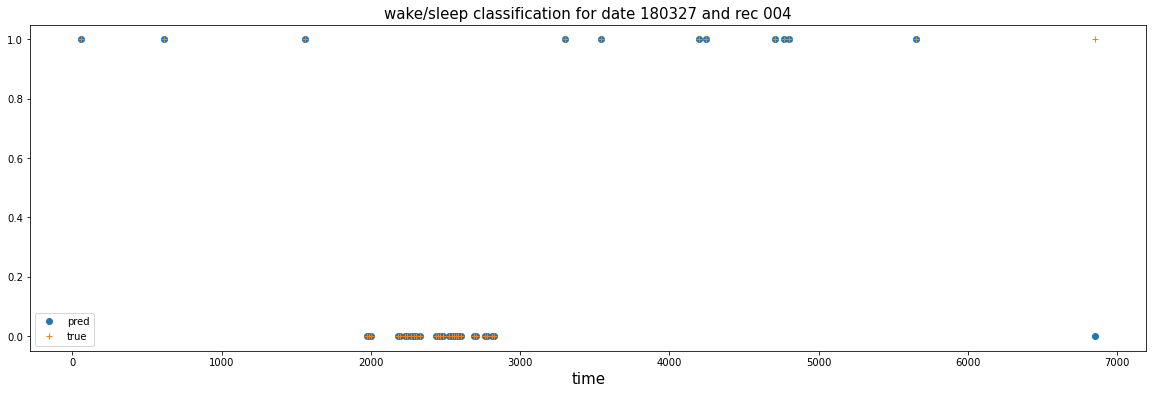

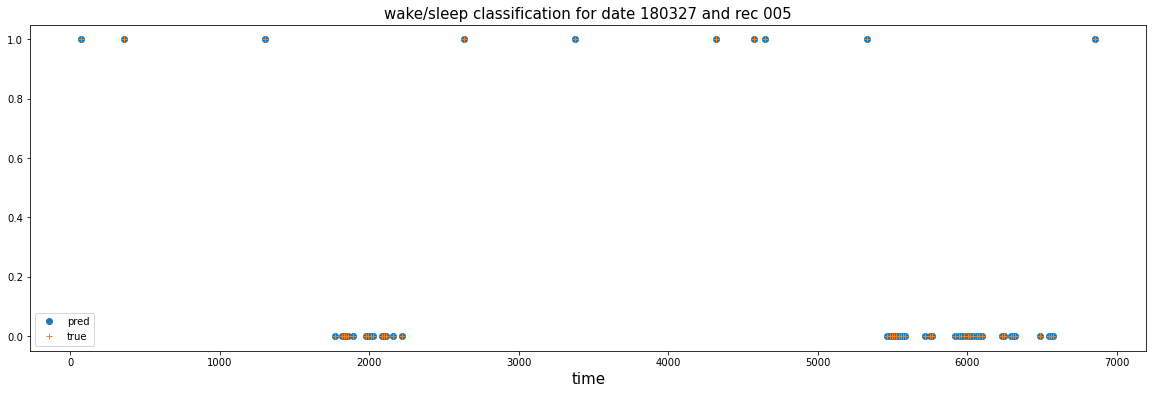

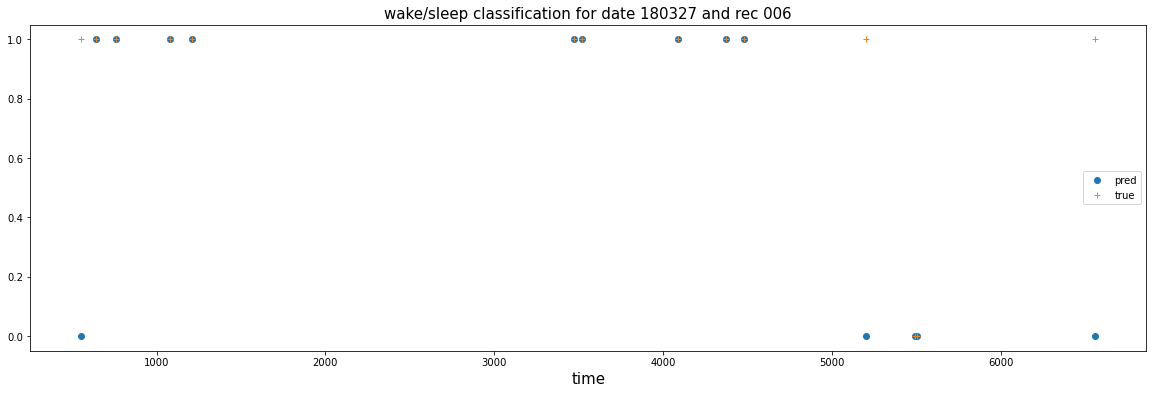

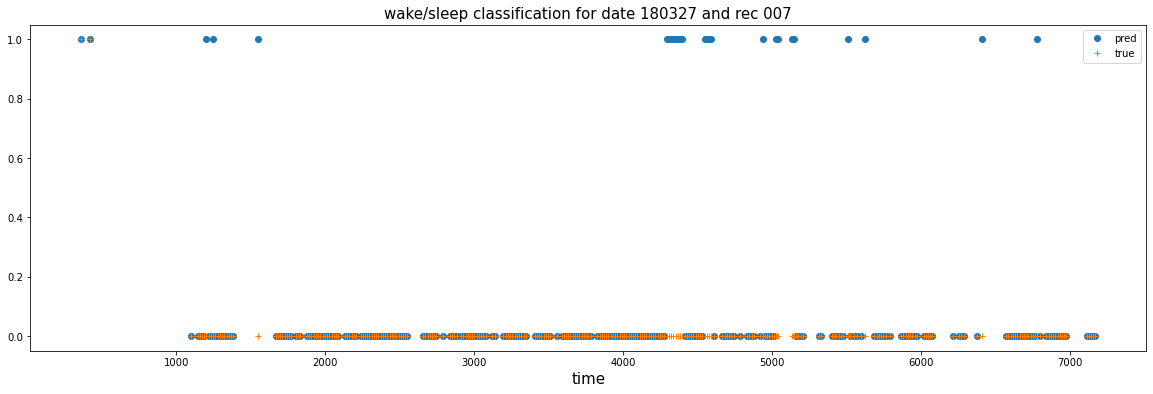

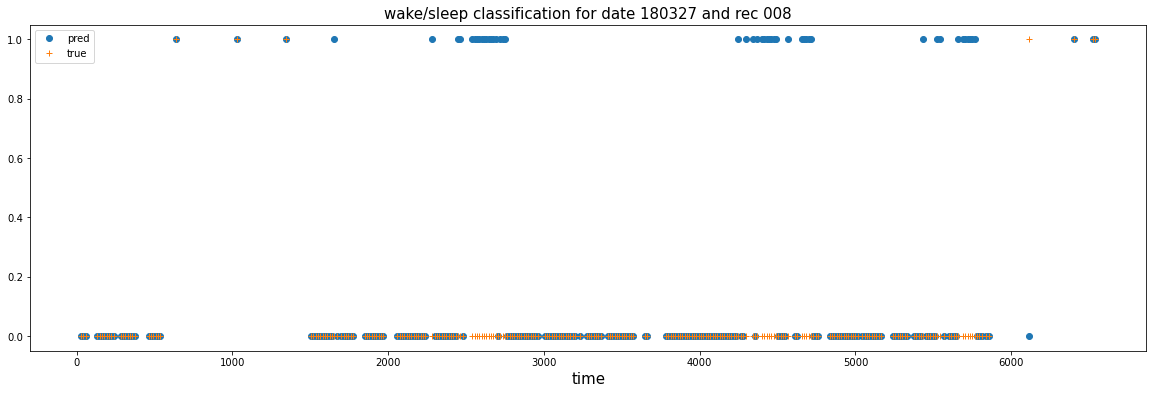

In [9]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.7157712578773499, train accuracy:0.8616223585548739, train percentage postive:0.5


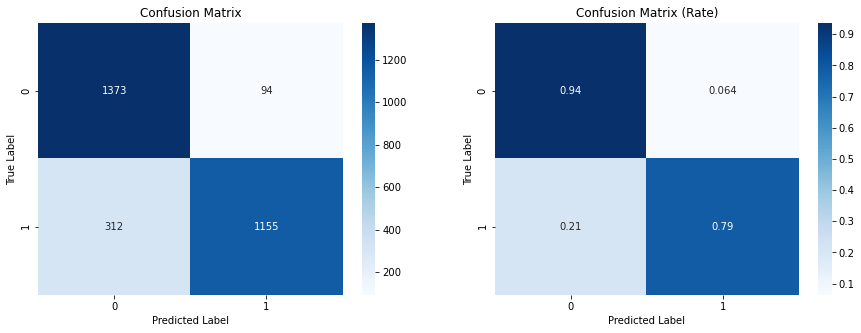

In [10]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [11]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'

0
Train loss for epoch 0: 7.761380672454834
Val loss for epoch 0: 6.8215250968933105
3
Train loss for epoch 3: 2.8059780597686768
Val loss for epoch 3: 5.374790668487549
4
Train loss for epoch 4: 1.3504247665405273
Val loss for epoch 4: 3.843743324279785
5
Train loss for epoch 5: 0.7995060682296753
Val loss for epoch 5: 2.695960521697998
6
Train loss for epoch 6: 0.5632020831108093
Val loss for epoch 6: 1.5353120565414429
7
Train loss for epoch 7: 0.4091358184814453
Val loss for epoch 7: 1.4341132640838623
8
Train loss for epoch 8: 0.29872724413871765
Val loss for epoch 8: 1.2101207971572876
9
Train loss for epoch 9: 0.22258798778057098
Val loss for epoch 9: 0.7881664037704468
12
Train loss for epoch 12: 0.08051568269729614
Val loss for epoch 12: 0.6534841656684875


0
Train loss for epoch 0: 7.435629844665527
Val loss for epoch 0: 7.473567485809326
2
Train loss for epoch 2: 5.5175323486328125
Val loss for epoch 2: 6.632501125335693
3
Train loss for epoch 3: 2.049696683883667
Val loss for epoch 3: 3.90644907951355
4
Train loss for epoch 4: 1.3503925800323486
Val loss for epoch 4: 3.8991851806640625
5
Train loss for epoch 5: 0.9055095911026001
Val loss for epoch 5: 1.7359657287597656
6
Train loss for epoch 6: 0.5054233074188232
Val loss for epoch 6: 1.1361143589019775
7
Train loss for epoch 7: 0.3599534034729004
Val loss for epoch 7: 0.932191014289856
8
Train loss for epoch 8: 0.44889506697654724
Val loss for epoch 8: 0.8552433252334595
15
Train loss for epoch 15: 0.28876882791519165
Val loss for epoch 15: 0.8384466171264648
17
Train loss for epoch 17: 0.2848140001296997
Val loss for epoch 17: 0.6448280215263367


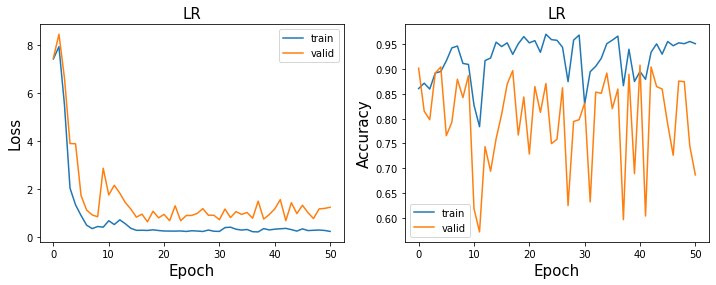

0
Train loss for epoch 0: 7.0988898277282715
Val loss for epoch 0: 7.247875213623047
2
Train loss for epoch 2: 3.0924153327941895
Val loss for epoch 2: 3.828744888305664
3
Train loss for epoch 3: 1.267350196838379
Val loss for epoch 3: 3.113612174987793
4
Train loss for epoch 4: 0.9752416610717773
Val loss for epoch 4: 1.2924696207046509
6
Train loss for epoch 6: 0.5254625082015991
Val loss for epoch 6: 0.7426568865776062
9
Train loss for epoch 9: 0.38953760266304016
Val loss for epoch 9: 0.6978018879890442
14
Train loss for epoch 14: 0.2799796164035797
Val loss for epoch 14: 0.657341480255127
21
Train loss for epoch 21: 0.35072794556617737
Val loss for epoch 21: 0.5490258932113647


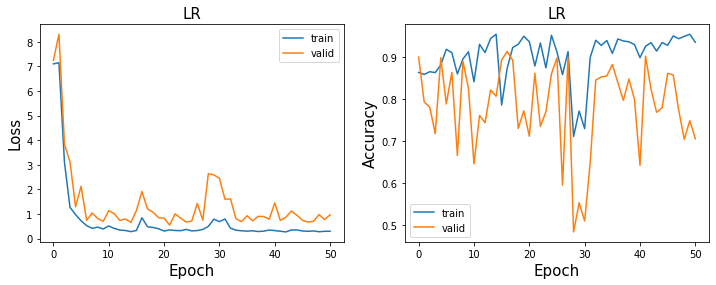

In [12]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.5490258932113647, val accuracy:0.8612143742255266, val percentage postive:0.0768277570605278


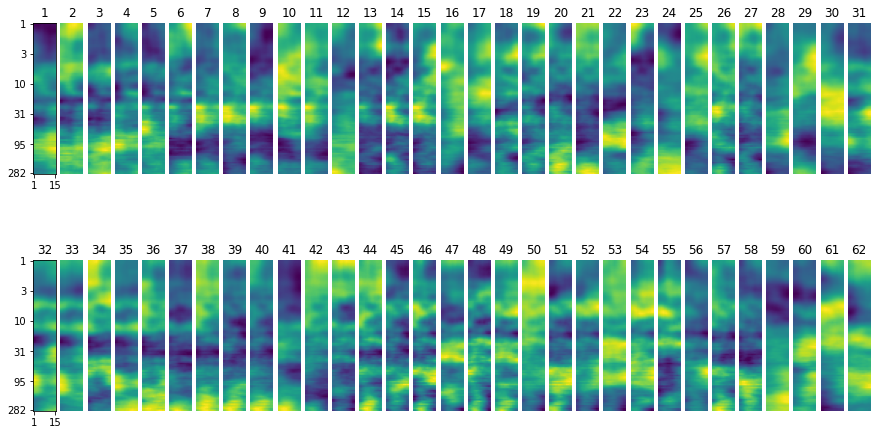

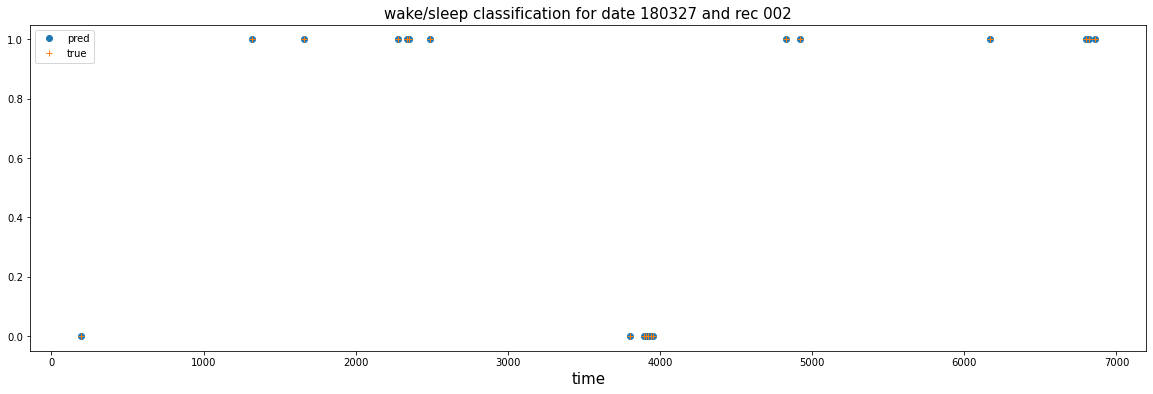

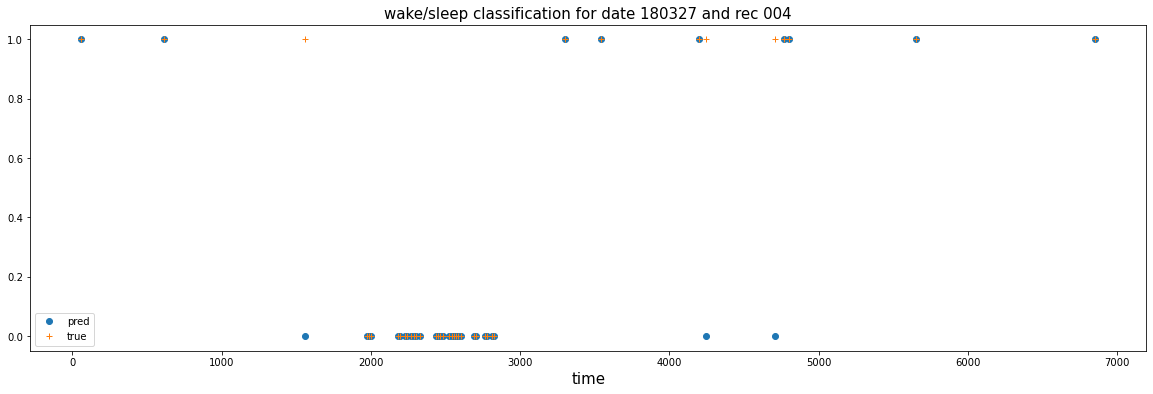

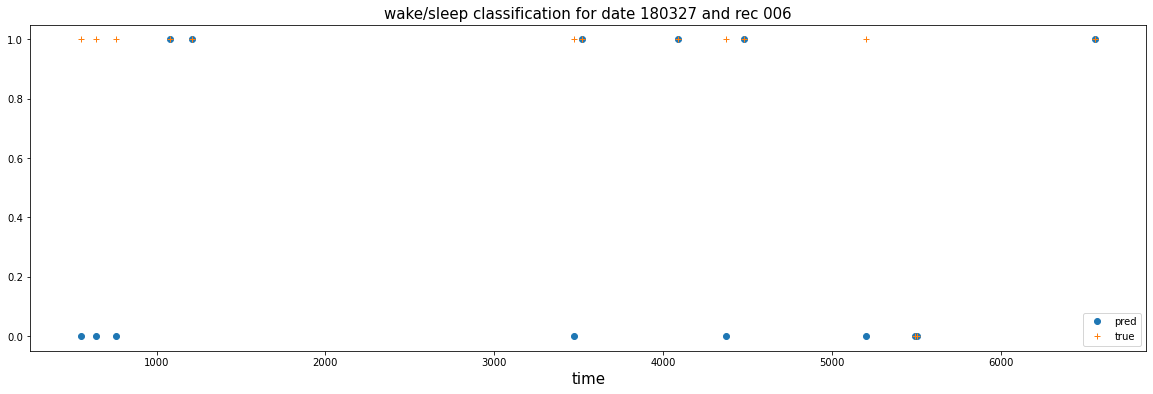

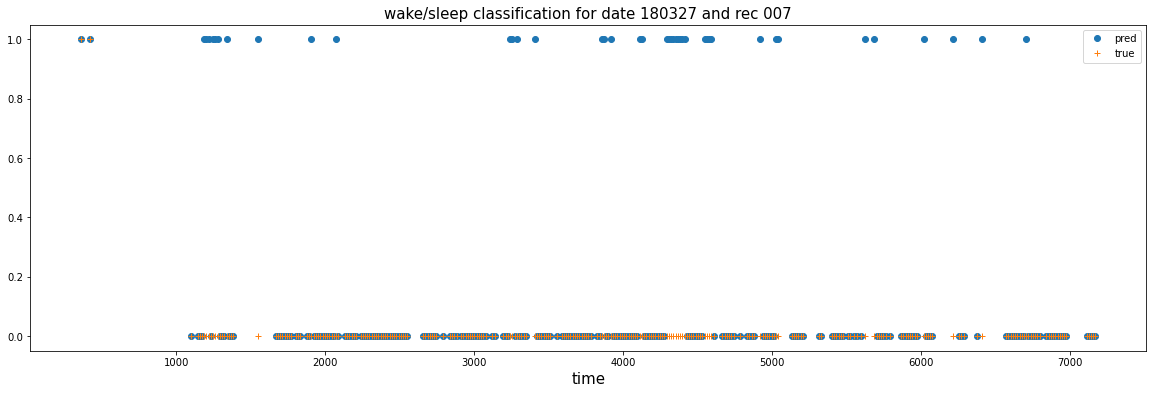

In [13]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.27148881554603577, train accuracy:0.9352419904567144, train percentage postive:0.5


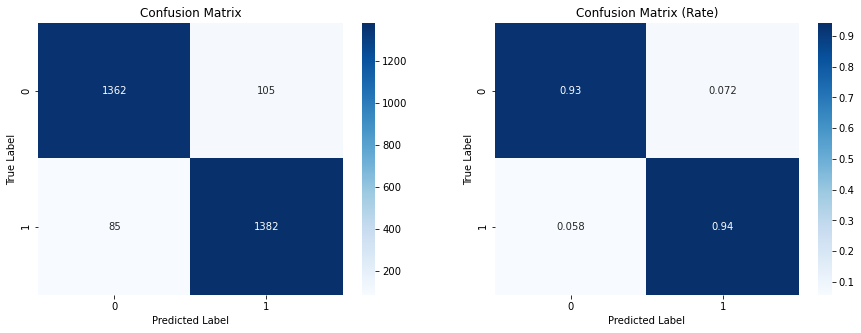

In [14]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)